In [60]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from datetime import datetime
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import warnings

# Cleaning

import pygame
import time

def play_audio(file_path, duration=8):  # Set default duration to 8 seconds
    pygame.mixer.init()
    pygame.mixer.music.load(file_path)
    pygame.mixer.music.play()

    start_time = time.time()  # Get the current time

    # Loop until the duration is reached
    while pygame.mixer.music.get_busy():
        current_time = time.time()
        if current_time - start_time > duration:  # Check if 8 seconds have passed
            break
        pygame.time.Clock().tick(10)

    pygame.mixer.music.stop()  # Stop the music after 8 seconds

# Call the function with your audio file
play_audio("take_on_me.mp3")

In [58]:
import pandas as pd
import json
from datetime import datetime, timedelta

# Load data
pop_data = pd.read_csv('../data/pop_data_cantons/weekly_imputed_pop_data_final_region.csv')
flu_data = pd.read_csv('../data/INFLUENZA_sentinella/data.csv')
weather_data = pd.read_csv('../data/weather/reg_weather.csv')
google_flu_data = pd.read_csv('../data/google_search_trend/reg_google_grippe.csv')
google_symptoms_data = pd.read_csv('../data/google_search_trend/reg_google_fieber_husten.csv')

# Processing flu_data
flu_CH = flu_data.query('georegion_type == "country" and agegroup == "all" and sex == "all"').copy()
flu_reg = flu_data.query('georegion_type == "sentinella_region" and agegroup == "all" and sex == "all"').copy()
flu_reg = flu_reg[~(flu_reg['georegion'] == 'unknown')]

selected_cols = ['temporal', 'georegion', 'popExtrapolation', 'incValue']
flu_reg = flu_reg[selected_cols]
flu_reg.rename(columns={'popExtrapolation': 'flu_cases'}, inplace=True)

# Align time-indexes of google data and flu data
with open('date_dict.json', 'r') as f:
    date_dict = json.load(f)

def align_dates(df):
    df['Woche'] = df['Woche'].apply(lambda x: date_dict.get(x, x))
    return df

google_flu_data = align_dates(google_flu_data)
google_symptoms_data = align_dates(google_symptoms_data)

# Convert dates to 'YYYY-Www' ISO week format
def convert_to_iso_week(date_str):
    year, week, _ = datetime.strptime(date_str, '%Y-%m-%d').isocalendar()
    return f'{year}-W{week:02d}'

weather_data['date'] = weather_data['date'].apply(convert_to_iso_week)

# Reshape and process Google data
def process_google_data(df):
    df = df.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')
    df['region'] = df['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
    df['query'] = df['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
    df.drop(columns='region_query', inplace=True)
    return df.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

google_flu_data = process_google_data(google_flu_data)
google_symptoms_data = process_google_data(google_symptoms_data)

# Merging datasets
merged_data = pd.merge(flu_reg, weather_data, how='left', left_on=['temporal', 'georegion'], right_on=['date', 'region'])
merged_google = pd.merge(google_flu_data, google_symptoms_data, how='inner', on=['region', 'Woche'])
merged_data = pd.merge(merged_data, merged_google, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Woche'])
merged_data = pd.merge(merged_data, pop_data, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Jahr-Woche'])
merged_data.drop(columns=['region_x', 'region_y', 'date', 'Woche_x', 'Woche_y', 'Jahr-Woche', 'Bevölkerung 31. Dezember'], inplace=True)

# Additional Functions
def iso_year_start(iso_year):
    fourth_jan = datetime(iso_year, 1, 4)
    delta = timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    year_start = iso_year_start(iso_year)
    return year_start + timedelta(days=iso_day-1, weeks=iso_week-1)

# Interpolating missing values in incValue column
lagged_df = merged_data.copy()
lagged_df['incValue'].interpolate(inplace=True)

lagged_df = merged_data.copy()
lagged_df['incValue'].interpolate(inplace=True)

# Extract week number and year from temporal and convert to dates
pattern = r'W(\d{1,2})'

# Ensure the extraction is properly applied to the Series
lagged_df['week_number'] = lagged_df['temporal'].str.extract(pattern)[0].astype(int)

lagged_df['year'] = lagged_df['temporal'].apply(lambda x: x.split('-')[0])
lagged_df['year'] = pd.to_numeric(lagged_df['year'])

# Convert from iso-calendar week to dates
lagged_df['date'] = list(map(lambda year, week: iso_to_gregorian(year, week, 4), lagged_df['year'], lagged_df['week_number']))

lagged_df.set_index('date', inplace=True)


df_with_dummies = pd.get_dummies(lagged_df, columns=['georegion'], drop_first=False)

df_with_dummies = df_with_dummies[df_with_dummies.index < "2020-01-01"]
df_with_dummies["temp_diff"] = df_with_dummies["weighted_max_daily_temp"] - df_with_dummies["weighted_min_daily_temp"]
df_with_dummies["hum_diff"] = df_with_dummies['weighted_max_daily_hum'] - df_with_dummies['weighted_min_daily_hum']

df_with_dummies = df_with_dummies.drop(['flu_cases',  'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)', "weighted_max_daily_temp",
                                        "weighted_min_daily_temp", 'weighted_max_daily_hum', 'weighted_min_daily_hum', 'Flu_resid', 'Flu_seasonal', 'Flu_trend',
                                        'Grippe_resid', 'Grippe_seasonal', 'Grippe_trend', 'Influenza_resid', 'Influenza_seasonal', 'Influenza_trend',
                                        'influenza_resid', 'influenza_seasonal', 'influenza_trend', 'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend',
                                        'fièvre_resid','fièvre_seasonal', 'fièvre_trend', 'husten_resid', 'husten_seasonal', 'husten_trend', 'toux_resid',
                                        'toux_seasonal', 'toux_trend', 'region', 'week_number', 'year'], axis = 1)

df_with_dummies

,incValue,weighted_avg_daily_temp,weighted_avg_daily_hum,Flu,Grippe,Influenza,influenza,Fieber,fièvre,husten,...,% over week,Pop Density,georegion_region_1,georegion_region_2,georegion_region_3,georegion_region_4,georegion_region_5,georegion_region_6,temp_diff,hum_diff
date,,,,,,,,,,,,,,,,,,,,,
2013-01-03,53.33,3.044123,82.918337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,537.516672,True,False,False,False,False,False,7.638725,31.321933
2013-01-03,53.58,2.666667,88.183333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,141.836685,False,True,False,False,False,False,6.833333,27.016667
2013-01-03,140.12,4.616667,84.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1593.502630,False,False,True,False,False,False,5.416667,17.833333
2013-01-03,96.16,3.833333,86.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,194.788178,False,False,False,True,False,False,5.450000,25.733333
2013-01-03,51.07,3.593942,85.519447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,277.565378,False,False,False,False,True,False,4.158725,26.465305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,68.25,3.571429,87.400000,16.098942,12.357706,12.185231,4.962824,28.978096,5.638709,19.114419,...,0.010528,151.566891,False,True,False,False,False,False,5.585714,21.700000
2019-12-26,18.45,4.914286,85.800000,6.447649,9.491382,6.921657,5.862196,17.070596,0.000000,31.403328,...,0.014078,1672.091664,False,False,True,False,False,False,5.385714,22.900000
2019-12-26,31.23,5.071429,79.742857,0.000000,5.730395,0.000000,39.494677,16.567904,0.000000,15.596453,...,0.009698,209.158901,False,False,False,True,False,False,4.228571,24.828571


In [66]:
exo = ['weighted_avg_daily_temp', 'weighted_avg_daily_hum', 'Flu',
       'Grippe', 'Influenza', 'influenza', 'Fieber', 'fièvre', 'husten',
       'toux', 'Geburten', 'Todesfälle', 'Überschuss',
       'Wanderungssaldo international 1', 'Wanderungssaldo interkantonal',
       'total', '% over Year', 'Alter 0–19', 'Alter 20–64',
       'Alter 65 und mehr', 'Mann', 'Frau', 'Schweizer', 'Ausländer ', 'Ledig',
       'Verheiratet', 'Verwitwet', 'Geschieden', 'Unverheiratet',
       'In eingetragener Partnerschaft', 'Aufgelöste Partnerschaft',
       'Städtischer Kernraum', 'Einflussgebiet Stadt',
       'Ausserhalb des Einflusses städtischer Kerne', 'BIP in Millionen CHF',
       'BIP Growth Laufende Preise', 'BIP Growth Preise Vorjahr',
       'BIP pro Kopf', 'Bevölkerung', '% over week', 'Pop Density']

# Dictionary to store the selected exogenous variables for each 'georegion_region_X'
georegion_dict = {}

# Iterate over 'georegion_region_X' keys
for i in range(1, 7):
    georegion_key = f'georegion_region_{i}'
    
    condition = df_with_dummies[georegion_key] == True

    # Filter the DataFrame based on the condition
    selected_data = df_with_dummies[condition][exo]

    # Add the selected exogenous variables to the dictionary
    georegion_dict[georegion_key] = selected_data

# Create a DataFrame from the dictionary
georegion_df = pd.concat(georegion_dict, axis=1)

georegion_df



georegion_region_1                                    \
           weighted_avg_daily_temp weighted_avg_daily_hum        Flu   
date                                                                   
2013-01-03                3.044123              82.918337        NaN   
2013-01-10                1.899121              85.732108   6.694163   
2013-01-17               -1.508554              77.031993  15.731896   
2013-01-24               -0.759157              77.826791  12.886953   
2013-01-31                4.551592              78.802057  20.251145   
...                            ...                    ...        ...   
2019-11-28                6.724039              88.105020   3.244992   
2019-12-05                3.763945              79.377926  19.935797   
2019-12-12                4.752568              79.667526   8.777801   
2019-12-19                6.510567              87.196960  18.358844   
2019-12-26                4.554182              85.366397   3.244992   

                                                                              \
               Grippe  Influenza  influenza     Fieber     fièvre     husten   
date                                                                           
2013-01-03        NaN        NaN        NaN        NaN        NaN        NaN   
2013-01-10  13.364971  12.730951   0.000000  14.012359  25.224384   3.724624   
2013-01-17   8.495091  16.742543   0.000000  31.712181  15.337335   7.977211   
2013-01-24  13.066783  18.003596  11.763678  14.719024  13.586975  16.034321   
2013-01-31  11.777776  16.342096   0.000000  10.902479  31.616718   3.797554   
...               ...        ...        ...        ...        ...        ...   
2019-11-28   6.615629  10.522407   4.235264  19.757225  11.914053  31.552315   
2019-12-05   7.611104   7.630654   2.884438  11.076038   9.949890   5.662897   
2019-12-12   8.985501  10.457205   6.352897  14.860496  32.047837  17.411128   
2019-12-19  11.934649  10.787698   0.000000  22.564568  20.121286  15.517533   
2019-12-26   7.682359  10.490402   2.861934   9.358686  16.382412   9.950007   

                       ...   georegion_region_6                       \
                 toux  ... Städtischer Kernraum Einflussgebiet Stadt   
date                   ...                                             
2013-01-03        NaN  ...             301470.0              98337.0   
2013-01-10  30.496017  ...             301544.0              98362.0   
2013-01-17  10.827069  ...             301617.0              98385.0   
2013-01-24  20.094055  ...             301691.0              98408.0   
2013-01-31  11.163364  ...             301765.0              98432.0   
...               ...  ...                  ...                  ...   
2019-11-28  26.854473  ...             314953.0             100716.0   
2019-12-05  24.178337  ...             314932.0             100710.0   
2019-12-12  18.264981  ...             314910.0             100704.0   
2019-12-19  35.118374  ...             314888.0             100697.0   
2019-12-26  17.405934  ...             314866.0             100691.0   

                                                                             \
           Ausserhalb des Einflusses städtischer Kerne BIP in Millionen CHF   
date                                                                          
2013-01-03                                    135765.0          43091.94171   
2013-01-10                                    135783.0          43091.94171   
2013-01-17                                    135802.0          43091.94171   
2013-01-24                                    135822.0          43091.94171   
2013-01-31                                    135841.0          43091.94171   
...                                                ...                  ...   
2019-11-28                                    134937.0          45927.05419   
2019-12-05                                    134942.0          45927.05419   
2019-12-

In [64]:
georegion_df["georegion_region_1"].columns

Index(['weighted_avg_daily_temp', 'weighted_avg_daily_hum', 'Flu', 'Grippe',
       'Influenza', 'influenza', 'Fieber', 'fièvre', 'husten', 'toux',
       'Geburten', 'Todesfälle', 'Überschuss',
       'Wanderungssaldo international 1', 'Wanderungssaldo interkantonal',
       'total', '% over Year', 'Alter 0–19', 'Alter 20–64',
       'Alter 65 und mehr', 'Mann', 'Frau', 'Schweizer', 'Ausländer ', 'Ledig',
       'Verheiratet', 'Verwitwet', 'Geschieden', 'Unverheiratet',
       'In eingetragener Partnerschaft', 'Aufgelöste Partnerschaft',
       'Städtischer Kernraum', 'Einflussgebiet Stadt',
       'Ausserhalb des Einflusses städtischer Kerne', 'BIP in Millionen CHF',
       'BIP Growth Laufende Preise', 'BIP Growth Preise Vorjahr',
       'BIP pro Kopf', 'Bevölkerung', '% over week', 'Pop Density'],
      dtype='object')

# Some feature engineering

In [ ]:
flu = pd.read_csv("data.csv")

flu["georegion"] = flu["georegion"].astype(str)
flu["sex"] = flu["sex"].astype(str)
#keep only the whole ch
flu = flu.loc[(flu["georegion"] == "CH") 
            & (flu["sex"] == "all") 
            & (flu["agegroup"] == "all")]
# Select only the desired columns
flu_clean = flu[["incValue", "temporal"]]
flu_clean = flu_clean.rename(columns={"incValue": "value"})

# Remove 'W' from the "temporal" column and replace any non-numeric characters
flu_clean["temporal"] = flu_clean["temporal"].str.replace('W', '')
#CHANGE into datetime
flu_clean["temporal"] = flu_clean["temporal"] + "-1"
flu_clean["temporal"] = pd.to_datetime(flu_clean["temporal"],format='%Y-%W-%w')
flu_clean = flu_clean.sort_values(by='temporal')

flu_clean.reset_index()
flu_clean['temporal'] = pd.to_datetime(flu_clean['temporal'])
flu_clean = flu_clean.set_index('temporal')
flu_clean.index = flu_clean.index.strftime('%Y-%m-%d')

train = flu_clean[:520]
test = flu_clean[520:]


train_imputed = train.copy()
imputer = KNNImputer(n_neighbors=10)
# Reshape the target column to a 2D array (required by the imputer)
train_import = train_imputed['value'].values.reshape(-1, 1)
train['value'] = imputer.fit_transform(train_import)
train['value'].isnull().any()
flu_clean_imputed = pd.concat([train, test], ignore_index=True)
train = flu_clean_imputed[:520]
test = flu_clean_imputed[520:]

train_missing_values = train.isnull().sum()
test_missing_values = test.isnull().sum()
print("Missing values in the train DataFrame:", train_missing_values)
print("\nMissing values in the test DataFrame:", test_missing_values)

FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

# Decomposition

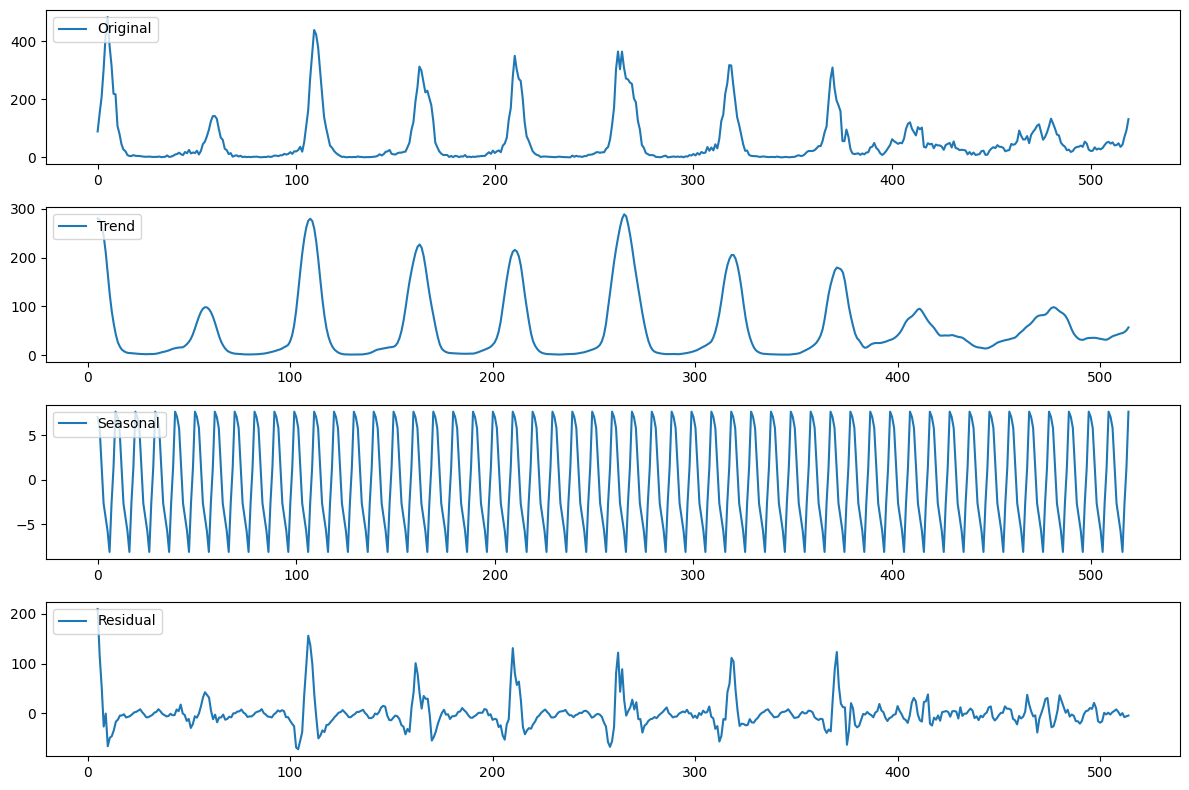

In [ ]:
# Perform seasonal decomposition
decomp = seasonal_decompose(train['value'], model='additive', period= 10)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Plot the components
plt.figure(figsize=(12, 8))

# Original Time Series
plt.subplot(4, 1, 1)
plt.plot(train['value'], label='Original')
plt.legend(loc='upper left')

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Residual Component
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# KPSS and ADF

In [ ]:
# Perform the KPSS test
result = kpss(train['value'])

# Print the test statistic and p-value
print(f'KPSS Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

# Compare the test statistic with critical values to make a decision
if result[1] < 0.05:
    print('The time series is non-stationary (reject the null hypothesis), need for differencing')
else:
    print('The time series is stationary (do not reject the null hypothesis), no need for differencing')

KPSS Test Statistic: 0.029873556700644392
P-value: 0.1
The time series is stationary (do not reject the null hypothesis), no need for differencing


/var/folders/__/36t3n6rx1l1fd_9216pzns100000gn/T/ipykernel_57879/2891729970.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(train['value'])


In [ ]:
# Perform the ADF test
result = adfuller(train['value'])

# Extract and print the test statistic and p-value
adf_statistic = result[0]
p_value = result[1]
print(f'ADF Test Statistic: {adf_statistic}')
print(f'P-value: {p_value}')

# Compare the test statistic with critical values to make a decision
if p_value < 0.05:
    print('The time series is stationary (reject the null hypothesis)')
else:
    print('The time series is non-stationary (do not reject the null hypothesis)')


ADF Test Statistic: -6.462700226513539
P-value: 1.4301334471180373e-08
The time series is stationary (reject the null hypothesis)


# ACF and PACF

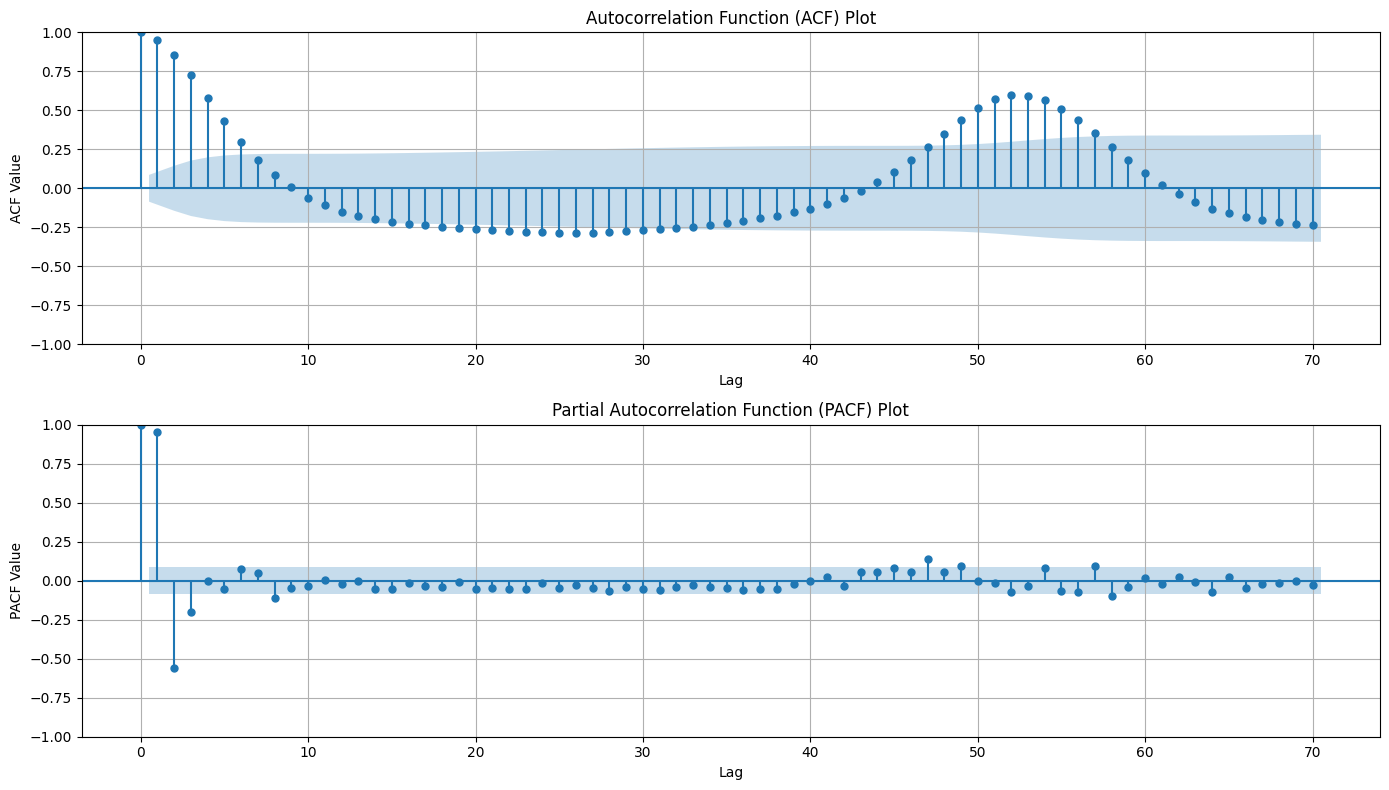

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(train['value'], lags=70, ax=axs[0])  # You can specify the number of lags to display
axs[0].set_title('Autocorrelation Function (ACF) Plot')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(train['value'], lags=70, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()

plt.tight_layout()
plt.show() 
# PACF shows the direct effect of each lag on yt, we can see that lag 1, 2, and 3 have the most impact on yt, and a drastic decaying after lag 3
# the decaying PACF also shows the y is not stationary 
# ACF shows that an order of lag 6 has an effect on yt
# Curving ACF suggests transformation??

# Log-transformation

## Redefine Train Test

In [ ]:
flu_clean_imputed['value_log'] = flu_clean_imputed['value'] + 1
y_log = np.log(flu_clean_imputed['value_log'])
if (flu_clean_imputed['value_log'] == 0).any():
    print("There are zeros in the column")
else:
    print("No zeros in the column")
flu_clean_imputed["log"] = y_log
flu_clean_imputed = flu_clean_imputed.drop('value_log', axis = 1)
train = flu_clean_imputed[:520]
test = flu_clean_imputed[520:]
print(train)
print(test)

No zeros in the column
      value       log
0     89.11  4.501031
1    151.28  5.025721
2    207.82  5.341473
3    302.56  5.715579
4    417.77  6.037322
..      ...       ...
515   36.01  3.611188
516   43.40  3.793239
517   70.87  4.274859
518   93.05  4.543827
519  131.60  4.887337

[520 rows x 2 columns]
      value       log
520  233.69  5.458265
521  137.35  4.929787
522   97.11  4.586089
523   95.61  4.570682
524   74.89  4.329285
525   63.35  4.164337
526   83.57  4.437580
527   95.04  4.564765
528   87.49  4.482890
529  108.51  4.696016
530   87.46  4.482550
531   90.91  4.520810
532   77.45  4.362461
533   75.37  4.335590
534   47.61  3.883829
535   46.49  3.860519
536   29.51  3.418054
537   23.41  3.194993
538   23.66  3.205182
539   22.95  3.175968
540   16.22  2.846071
541   12.58  2.608598
542   14.73  2.755570
543    9.30  2.332144
544   12.05  2.568788
545    7.70  2.163323
546   11.29  2.508786
547    6.01  1.947338
548    6.56  2.022871
549    8.69  2.271094
550    

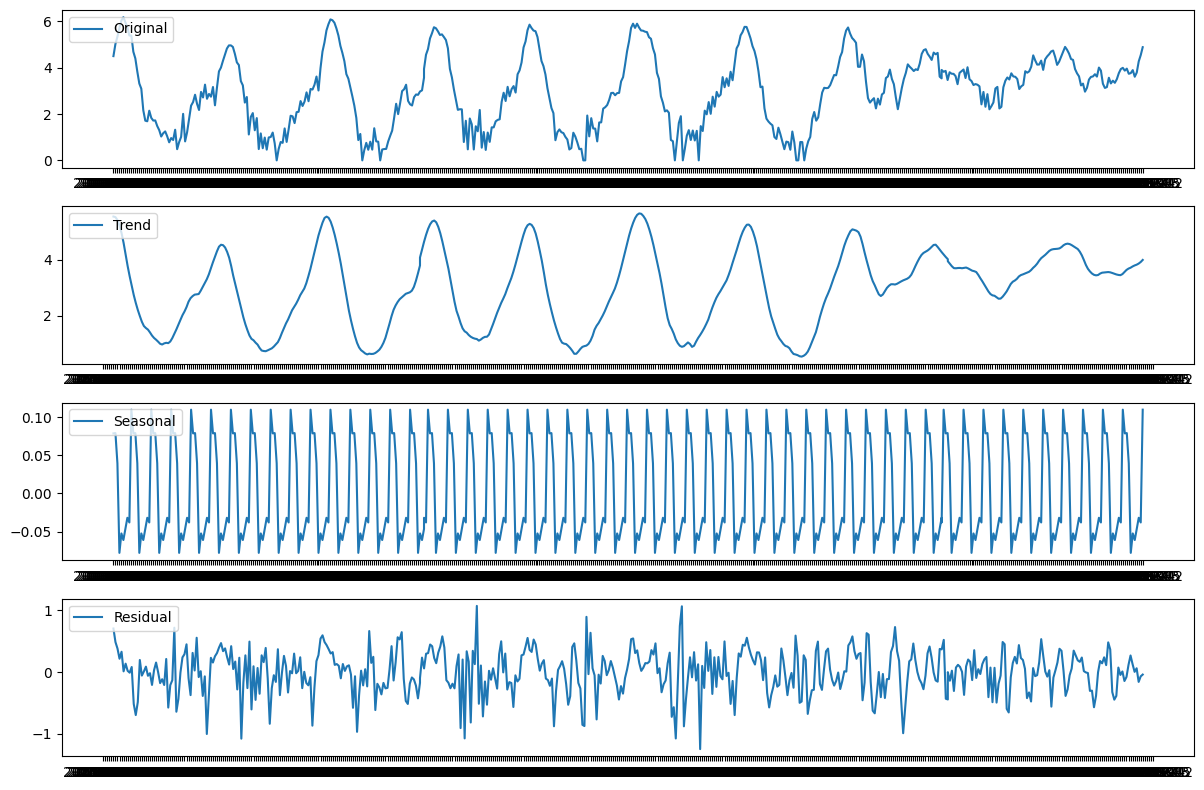

In [ ]:
decomp = seasonal_decompose(train['log'], model='additive', period= 10)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Plot the components
plt.figure(figsize=(12, 8))

# Original Time Series
plt.subplot(4, 1, 1)
plt.plot(train['log'], label='Original')
plt.legend(loc='upper left')

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Residual Component
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
# The pattern in residual disappears afetr log transformation, which implies stationary

## KPSS and ADF with Log_transformation

In [ ]:
# Perform the KPSS test
result = kpss(train['log'])

# Print the test statistic and p-value
print(f'KPSS Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

# Compare the test statistic with critical values to make a decision
if result[1] < 0.05:
    print('The time series is non-stationary (reject the null hypothesis), need for differencing')
else:
    print('The time series is stationary (do not reject the null hypothesis), no need for differencing')

KPSS Test Statistic: 0.29293896293319127
P-value: 0.1
The time series is stationary (do not reject the null hypothesis), no need for differencing


/var/folders/__/36t3n6rx1l1fd_9216pzns100000gn/T/ipykernel_57879/1446348268.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(train['log'])


In [ ]:
# Perform the ADF test
result = adfuller(train['log'])

# Extract and print the test statistic and p-value
adf_statistic = result[0]
p_value = result[1]
print(f'ADF Test Statistic: {adf_statistic}')
print(f'P-value: {p_value}')

# Compare the test statistic with critical values to make a decision
if p_value < 0.05:
    print('The time series is stationary (reject the null hypothesis)')
else:
    print('The time series is non-stationary (do not reject the null hypothesis)')

ADF Test Statistic: -6.2907249954287385
P-value: 3.604847775868224e-08
The time series is stationary (reject the null hypothesis)


## ACF and PACF on Log-transformation

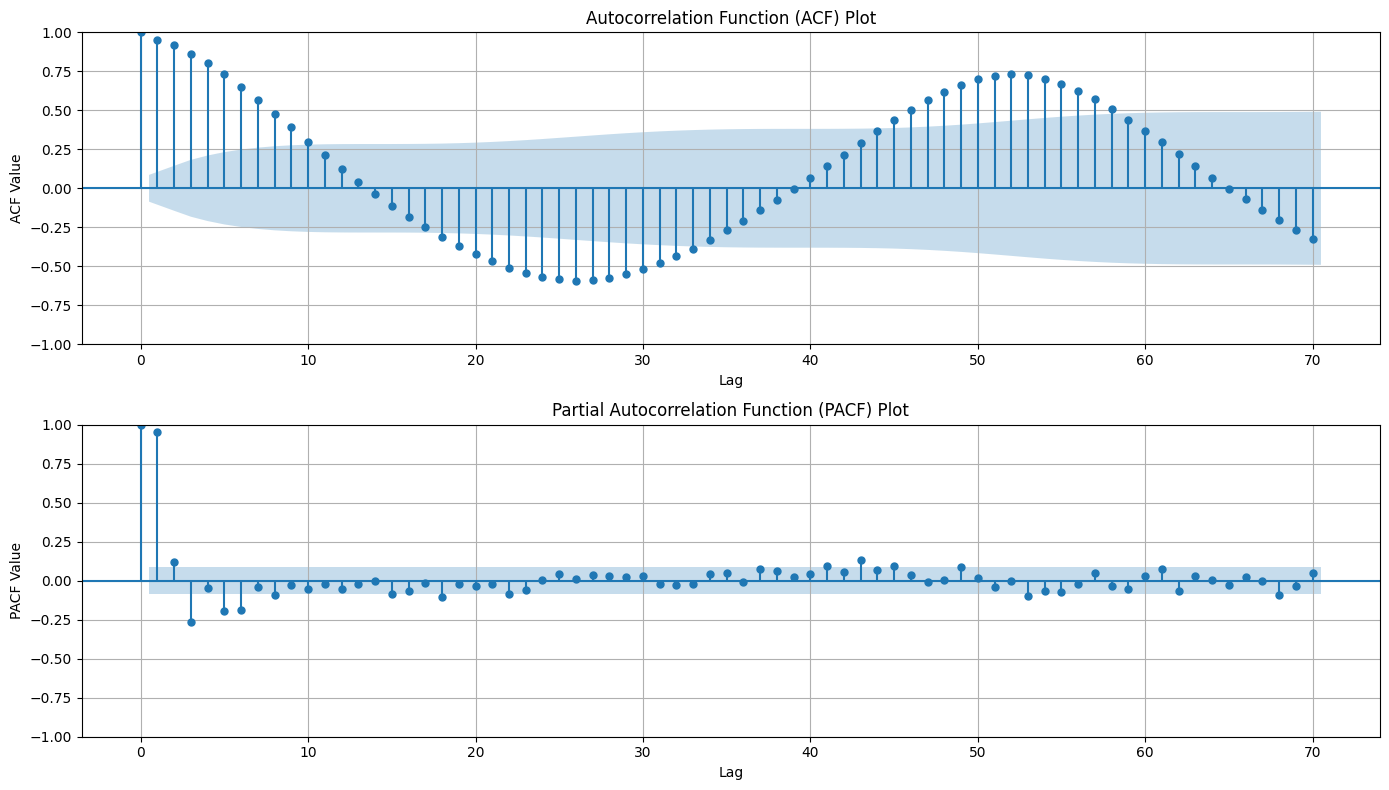

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(train["log"], lags=70, ax=axs[0])  # You can specify the number of lags to display
axs[0].set_title('Autocorrelation Function (ACF) Plot')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(train["log"], lags=70, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()

plt.tight_layout()
plt.show() 
# ACF decays slowly with a sine-wave like patterm.
# PACF show no sigficiant spike after 6th lag
# From ACF and PACF we could induce that it could be a AR(6) model, meaning arima (6,0,0)

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                  520
Model:                 ARIMA(6, 0, 0)   Log Likelihood                -293.313
Date:                Thu, 07 Dec 2023   AIC                            602.627
Time:                        11:48:45   BIC                            636.657
Sample:                             0   HQIC                           615.958
                                - 520                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0158      0.284     10.628      0.000       2.460       3.572
ar.L1          0.8053      0.041     19.507      0.000       0.724       0.886
ar.L2          0.3524      0.047      7.517      0.0

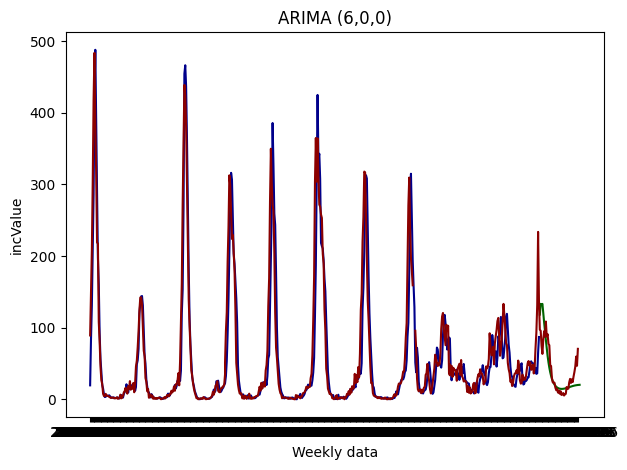

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np
import warnings

model = ARIMA(train["log"], order=(6, 0, 0))
model_arima = model.fit()
print(model_arima.summary())

pred_test = model_arima.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
pred_test = np.exp(pred_test) - 1
pred_test = pd.DataFrame({'pred': pred_test})
pred_test.index = test.index

pred_train = model_arima.predict(start=0, end=len(train)- 1, dynamic=False)
pred_train = np.exp(pred_train) - 1
pred_train = pd.DataFrame({'pred': pred_train})
pred_train.index = train.index

plt.title("ARIMA (6,0,0)")
plt.ylabel("incValue")
plt.xlabel("Weekly data")
plt.plot(pred_train, color = "darkblue", label = "predicted")
plt.plot(pred_test, color = "darkgreen")
plt.plot(flu_clean['value'], color = "darkred", label = "actual")
plt.tight_layout()
plt.show

print(mean_squared_error(test["value"], pred_test, squared= False))
# Predition is not very good, we can see it flattens out and converge to a constant.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np
import warnings
warnings.filterwarnings('ignore')

H = 4
aic_values = {}
RMSE = {}

d = 0

for p in range(4, 10):
    for q in range(6, 12):
        temp_aic_values = []
        temp_rmse_values = []

        for t in range(260, len(train) + 1, H):
            train_end = t
            test_start = train_end + H
            test_end = test_start + H

            current_train = flu_clean_imputed.iloc[:train_end]
            current_test = flu_clean_imputed.iloc[test_start:test_end]
            model = ARIMA(current_train["log"], order=(p, d, q))
            model_arima = model.fit()
            temp_aic_values.append(model_arima.aic)

            pred = model_arima.predict(start=test_start, end=test_end-1, dynamic=False)
            pred = np.exp(pred) - 1
            pred_data = pd.DataFrame({'pred': pred})
            pred_data.index = current_test.index
            rmse_value = mean_squared_error(current_test["value"], pred_data, squared=False)
            temp_rmse_values.append(rmse_value)

        average_aic = np.mean(temp_aic_values)
        aic_values[(p, d, q)] = average_aic
        average_rmse = np.mean(temp_rmse_values)
        RMSE[(p, d, q)] = average_rmse

        print(f"ARIMA({p}, {d}, {q}) with average AIC: {average_aic}, average RMSE is {average_rmse}")

# Finding the best parameters
best_pdq_aic = min(aic_values, key=aic_values.get)
print("Lowest AIC ARIMA is:", best_pdq_aic, aic_values[best_pdq_aic])

best_pdq_rmse = min(RMSE, key=RMSE.get)
print("Lowest RMSE ARIMA is:", best_pdq_rmse, RMSE[best_pdq_rmse])


ARIMA(4, 0, 6) with average AIC: 470.2895155176518, average RMSE is 47.374674584541715
ARIMA(4, 0, 7) with average AIC: 473.3107013277699, average RMSE is 46.89928129290731
ARIMA(4, 0, 8) with average AIC: 478.6805629727143, average RMSE is 47.17700006128381
ARIMA(4, 0, 9) with average AIC: 476.2328969170742, average RMSE is 46.10624741916859
ARIMA(4, 0, 10) with average AIC: 479.81865943494637, average RMSE is 46.749848159340196
ARIMA(4, 0, 11) with average AIC: 474.69816179491517, average RMSE is 43.415668659820916
ARIMA(5, 0, 6) with average AIC: 472.3445114023769, average RMSE is 46.779314775552436
ARIMA(5, 0, 7) with average AIC: 479.2209407418964, average RMSE is 46.65887673003776
ARIMA(5, 0, 8) with average AIC: 477.4885671663333, average RMSE is 45.06983569252936
ARIMA(5, 0, 9) with average AIC: 477.5874521508587, average RMSE is 44.16090320549443
ARIMA(5, 0, 10) with average AIC: 480.6823031628896, average RMSE is 48.393814007422066
ARIMA(5, 0, 11) with average AIC: 471.895661

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                  520
Model:                ARIMA(6, 0, 11)   Log Likelihood                -273.287
Date:                Thu, 07 Dec 2023   AIC                            584.575
Time:                        13:33:09   BIC                            665.397
Sample:                             0   HQIC                           616.236
                                - 520                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8808      0.191     15.102      0.000       2.507       3.255
ar.L1          0.3782      0.090      4.203      0.000       0.202       0.555
ar.L2          1.8226      0.094     19.362      0.0

<function matplotlib.pyplot.show(close=None, block=None)>

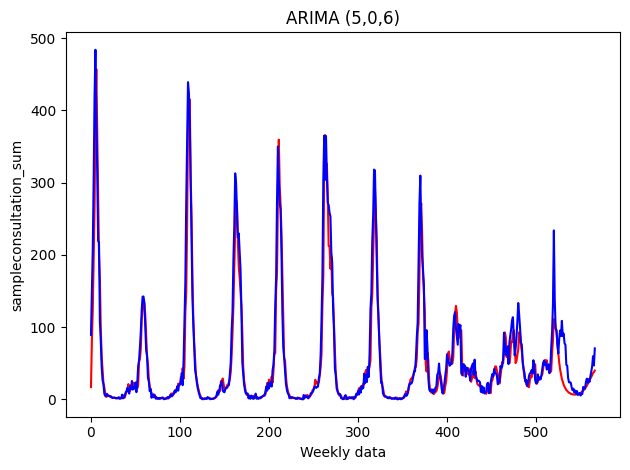

In [ ]:
train = flu_clean_imputed[:520]
test = flu_clean_imputed[520:]

model = ARIMA(train["log"], order=(6, 0, 11))
model_arima = model.fit()
print(model_arima.summary())

pred = model_arima.predict(start=0, end=len(flu_clean_imputed) - 1, dynamic=False)
pred = np.exp(pred) - 1
pred_data = pd.DataFrame({'pred': pred})
pred_data.index = flu_clean_imputed.index

plt.title("ARIMA (5,0,6)")
plt.ylabel("sampleconsultation_sum")
plt.xlabel("Weekly data")
plt.plot(pred_data, color = "red", label = "predicted")
plt.plot(flu_clean_imputed['value'], color = "blue", label = "actual")
plt.tight_layout()
plt.show

## 1st Order Differencing

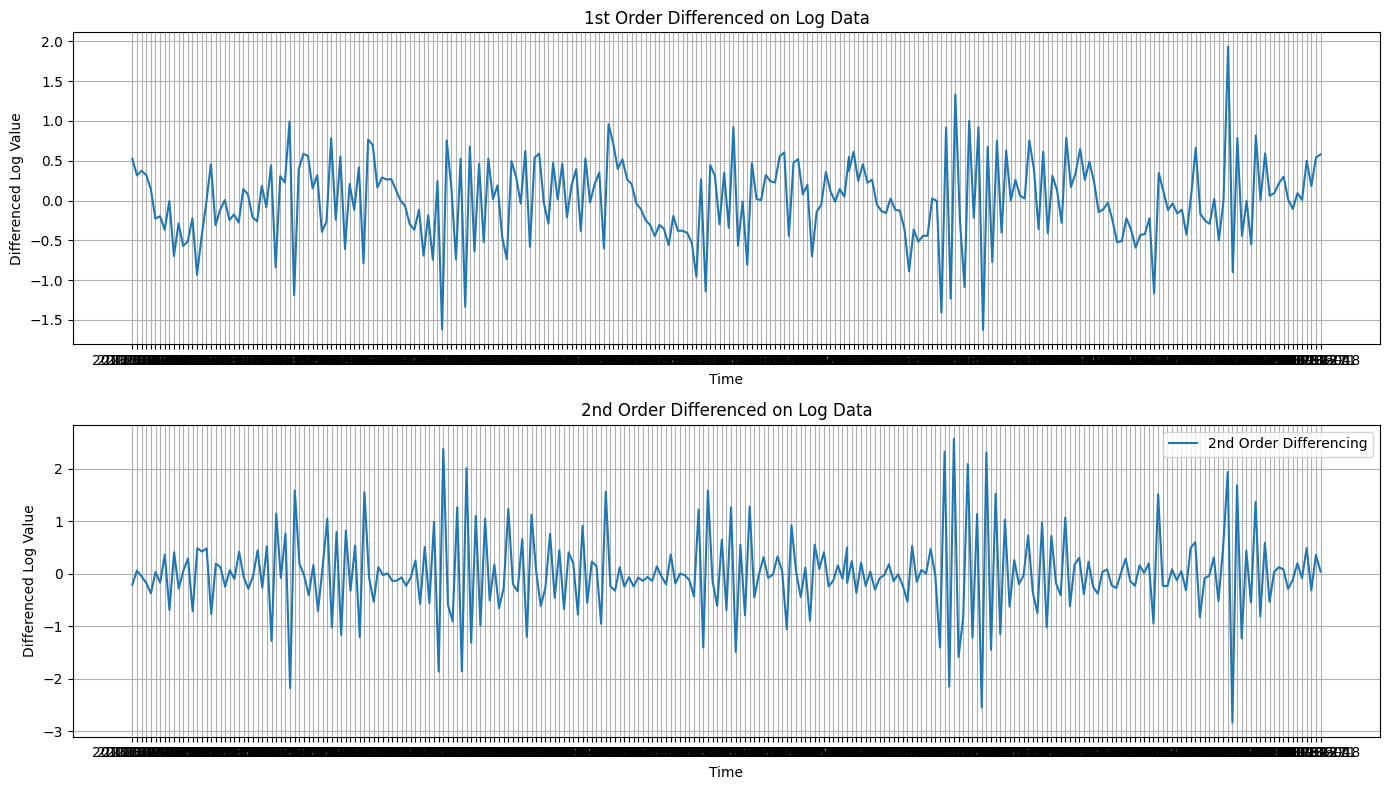

In [ ]:
diff = pd.DataFrame(train["log"].diff())
diff = diff.dropna()

diff2 = pd.DataFrame(diff["log"].diff())
diff2 = diff2.dropna()

fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot for 1st Order Differencing
axs[0].plot(diff, label='1st Order Differencing')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Differenced Log Value')
axs[0].set_title('1st Order Differenced on Log Data')
axs[0].grid()  # Add grid to the first plot

# Plot for 2nd Order Differencing
axs[1].plot(diff2, label='2nd Order Differencing')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Differenced Log Value')
axs[1].set_title('2nd Order Differenced on Log Data')
axs[1].grid()

plt.tight_layout()
plt.legend()
plt.show()
# Even though the tests above tells us there is no need for differencing, we still do it but the pattern persists.

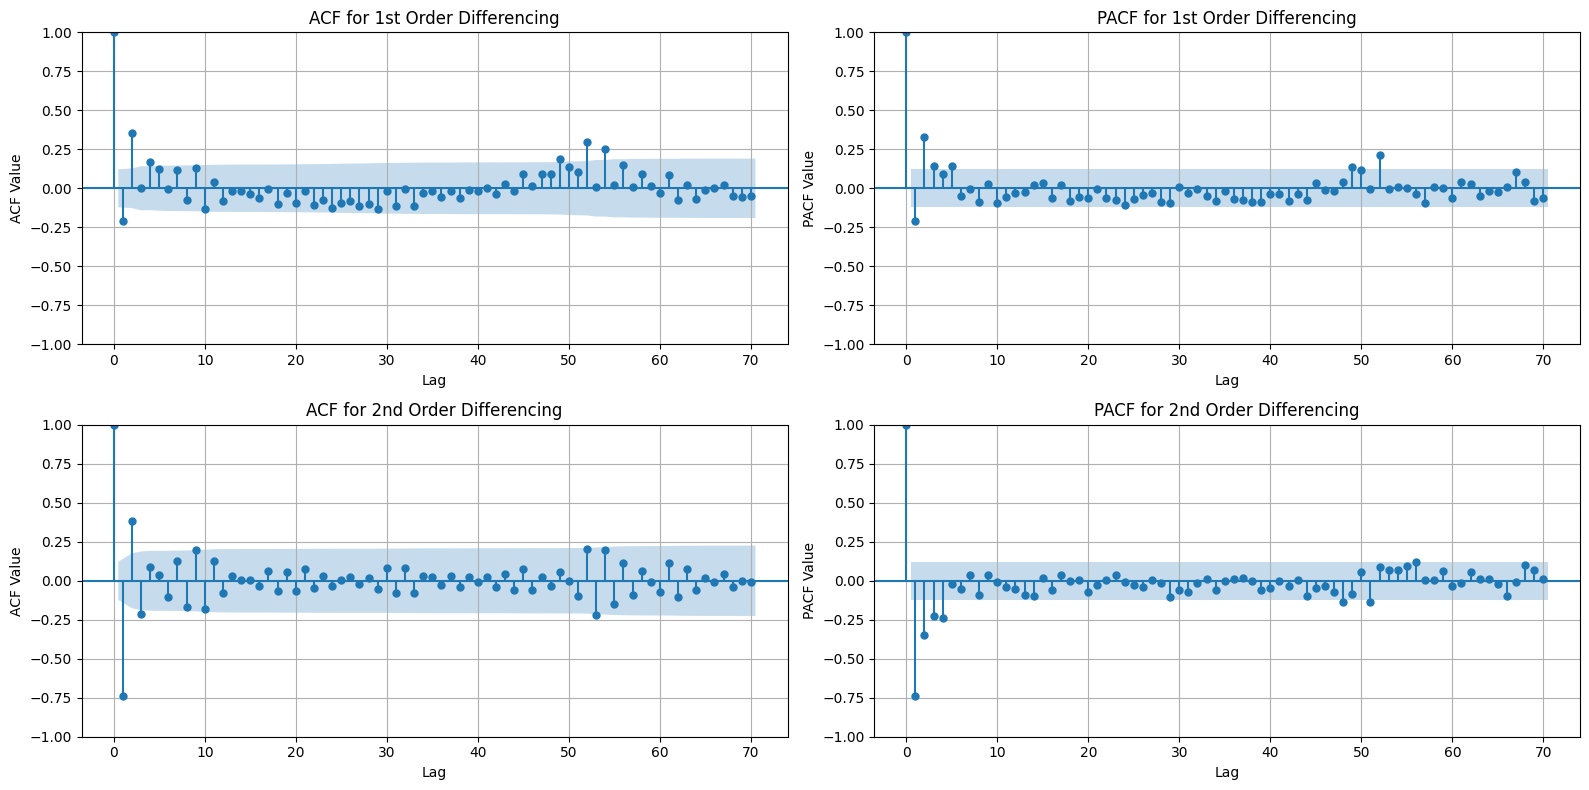

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Plot ACF for diff
plot_acf(diff, lags=70, ax=axs[0, 0])
axs[0, 0].set_title('ACF for 1st Order Differencing')
axs[0, 0].set_xlabel('Lag')
axs[0, 0].set_ylabel('ACF Value')
axs[0, 0].grid()

# Plot PACF for diff
plot_pacf(diff, lags=70, ax=axs[0, 1])
axs[0, 1].set_title('PACF for 1st Order Differencing')
axs[0, 1].set_xlabel('Lag')
axs[0, 1].set_ylabel('PACF Value')
axs[0, 1].grid()

# Plot ACF for diff2
plot_acf(diff2, lags=70, ax=axs[1, 0])
axs[1, 0].set_title('ACF for 2nd Order Differencing')
axs[1, 0].set_xlabel('Lag')
axs[1, 0].set_ylabel('ACF Value')
axs[1, 0].grid()

# Plot PACF for diff2
plot_pacf(diff2, lags=70, ax=axs[1, 1])
axs[1, 1].set_title('PACF for 2nd Order Differencing')
axs[1, 1].set_xlabel('Lag')
axs[1, 1].set_ylabel('PACF Value')
axs[1, 1].grid()

plt.tight_layout()
plt.show()
# Decaying ACF and PACF for 1st order differencing and 2nd order differencing
# possible another differencing method?

## Seasonal Differencing

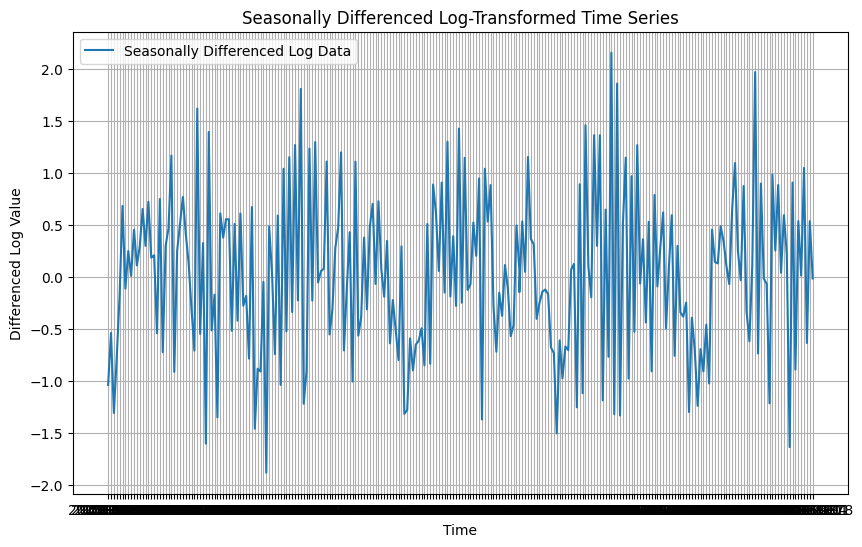

In [ ]:
# Define the lag (seasonal period)
lag = 12 # For yearly seasonality (e.g., weekly data)

# Perform seasonal differencing on the log-transformed data
seasonal_differenced_data = diff.diff(lag)

# Drop NaN values (resulting from the diff operation)
seasonal_differenced_data = seasonal_differenced_data.dropna()

# Now, seasonal_differenced_data contains the seasonally differenced log-transformed data
plt.figure(figsize=(10, 6))
plt.plot(seasonal_differenced_data, label='Seasonally Differenced Log Data')
plt.title('Seasonally Differenced Log-Transformed Time Series')
plt.xlabel('Time')
plt.ylabel('Differenced Log Value')
plt.legend()
plt.grid()
plt.show()
# After seasonl differencing on log-transformation, it seems to be stationary.

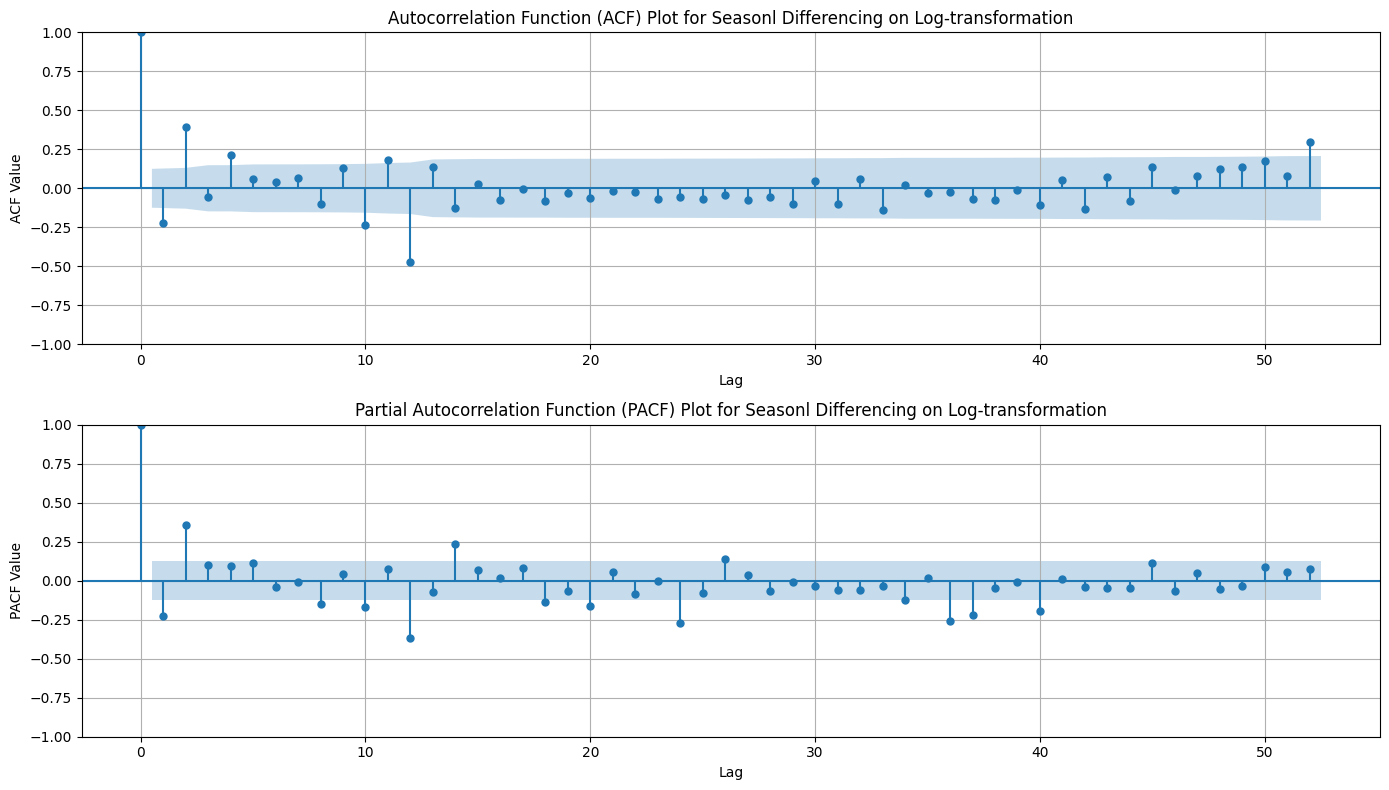

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(seasonal_differenced_data, lags=52, ax=axs[0])  # You can specify the number of lags to display
axs[0].set_title('Autocorrelation Function (ACF) Plot for Seasonl Differencing on Log-transformation')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(seasonal_differenced_data, lags=52, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot for Seasonl Differencing on Log-transformation')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()

plt.tight_layout()
plt.show()
# Decay ACF and PACF is a good sign for stationality
#From ACF and PACF we could induce that the optimum mivong average is 10 and the autoregressive order is 4.

# ARIMA

expanding cross validation will be used because the dataset is quite small with unexpected spikes

In [ ]:
print(len(train))

260


# SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import warnings
from joblib import Parallel, delayed
import multiprocessing

warnings.filterwarnings('ignore')

H = 13
p = 1
d = 0
q = 1
D = 1
S = 12

def run_sarima(P, Q, train, test):
    model_sarima = SARIMAX(train['log'], order=(p, d, q), seasonal_order=(P, D, Q, S)).fit(disp=0)
    aic = model_sarima.aic

    pred_sarima = model_sarima.predict(start=test.index[0], end=test.index[-1], dynamic=False)
    pred_sarima = np.exp(pred_sarima) - 1
    rmse_value = mean_squared_error(test["value"], pred_sarima, squared=False)

    return aic, rmse_value

results = {}

num_cores = multiprocessing.cpu_count()
for P in range(1, 3):
    for Q in range(1, 3):
        aic_values = []
        rmse_values = []

        parallel_results = Parallel(n_jobs=num_cores)(delayed(run_sarima)(P, Q, flu_clean_imputed.iloc[:t], flu_clean_imputed.iloc[t:t+H]) for t in range(260, len(train) + 1, H))

        for aic, rmse in parallel_results:
            aic_values.append(aic)
            rmse_values.append(rmse)

        average_aic = np.mean(aic_values)
        average_rmse = np.mean(rmse_values)
        results[(p, d, q, P, D, Q, S)] = (average_aic, average_rmse)
        print(f"SARIMA({p}, {d}, {q}, {P}, {D}, {Q}, {S}) with average AIC: {average_aic}, average RMSE is {average_rmse}")

# Extracting the best models
best_pdq_aic = min(results, key=lambda x: results[x][0])
best_pdq_rmse = min(results, key=lambda x: results[x][1])

print("Lowest AIC SARIMA is:", best_pdq_aic, results[best_pdq_aic][0])
print("Lowest RMSE SARIMA is:", best_pdq_rmse, results[best_pdq_rmse][1])


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import warnings
from sklearn.metrics import mean_squared_error
import pandas as pd

warnings.filterwarnings('ignore')

H = 13
aic_values = {}
RMSE = {}
average_aic_values = {}
average_rmse_values = {}

p = 6
d = 0
q = 8
D = 1
S = 12

for P in range(1, 5):
    for Q in range(1, 8):
        current_aic_values = []
        current_rmse_values = []

        for t in range(260, len(train) + 1, H):
            train_end = t
            test_start = train_end + H
            test_end = test_start + H

            current_train = flu_clean_imputed.iloc[:train_end]
            current_test = flu_clean_imputed.iloc[test_start:test_end]

            model_sarima = SARIMAX(current_train['log'],
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, S)).fit()
            aic = model_sarima.aic
            current_aic_values.append(aic)

            pred_sarima = model_sarima.predict(start=test_start, end=test_end-1, dynamic=False)
            pred_sarima = np.exp(pred_sarima) - 1
            pred_data_sarima = pd.DataFrame({'pred': pred_sarima})
            pred_data_sarima.index = current_test.index
            rmse_value = mean_squared_error(current_test["value"], pred_data_sarima, squared=False)
            current_rmse_values.append(rmse_value)

        average_aic = np.mean(current_aic_values)
        average_rmse = np.mean(current_rmse_values)

        aic_values[(p, d, q, P, D, Q, S)] = average_aic
        RMSE[(p, d, q, P, D, Q, S)] = average_rmse

        print(f"SARIMA({p}, {d}, {q}, {P}, {D}, {Q}, {S}) with average AIC: {average_aic}, average RMSE is {average_rmse}")

best_pdq_aic = min(aic_values, key=aic_values.get)
print("Lowest AIC SARIMA is:", best_pdq_aic, aic_values[best_pdq_aic])

best_pdq_rmse = min(RMSE, key=RMSE.get)
print("Lowest RMSE SARIMA is:", best_pdq_rmse, RMSE[best_pdq_rmse])

play_audio("take_on_me.mp3")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91873D-01    |proj g|=  5.28305D-01


 This problem is unconstrained.



At iterate    5    f=  6.93553D-01    |proj g|=  6.73750D-02

At iterate   10    f=  6.34700D-01    |proj g|=  7.94568D-02

At iterate   15    f=  6.31931D-01    |proj g|=  7.98204D-03

At iterate   20    f=  6.30435D-01    |proj g|=  2.81057D-03

At iterate   25    f=  6.29915D-01    |proj g|=  1.52821D-02

At iterate   30    f=  6.29482D-01    |proj g|=  1.74939D-03

At iterate   35    f=  6.29003D-01    |proj g|=  1.13616D-02

At iterate   40    f=  6.27299D-01    |proj g|=  1.06332D-02

At iterate   45    f=  6.26592D-01    |proj g|=  1.34555D-02

At iterate   50    f=  6.25836D-01    |proj g|=  3.66114D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.77833D-01    |proj g|=  6.88729D-02

At iterate   10    f=  6.18493D-01    |proj g|=  3.41124D-02

At iterate   15    f=  6.14403D-01    |proj g|=  1.94924D-02

At iterate   20    f=  6.13367D-01    |proj g|=  2.01308D-02

At iterate   25    f=  6.13142D-01    |proj g|=  6.22254D-03

At iterate   30    f=  6.12880D-01    |proj g|=  4.29445D-03

At iterate   35    f=  6.12627D-01    |proj g|=  4.33566D-03

At iterate   40    f=  6.12393D-01    |proj g|=  1.76434D-02

At iterate   45    f=  6.11905D-01    |proj g|=  4.28867D-02

At iterate   50    f=  6.11188D-01    |proj g|=  7.83469D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.79713D-01    |proj g|=  1.06811D-01

At iterate   10    f=  6.32880D-01    |proj g|=  2.68897D-02

At iterate   15    f=  6.30031D-01    |proj g|=  1.71517D-02

At iterate   20    f=  6.29104D-01    |proj g|=  2.88387D-03

At iterate   25    f=  6.28939D-01    |proj g|=  5.96324D-03

At iterate   30    f=  6.28412D-01    |proj g|=  6.67098D-03

At iterate   35    f=  6.28079D-01    |proj g|=  1.01835D-02

At iterate   40    f=  6.27001D-01    |proj g|=  9.79803D-03

At iterate   45    f=  6.26596D-01    |proj g|=  6.20319D-03

At iterate   50    f=  6.26215D-01    |proj g|=  1.67777D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.08999D-01    |proj g|=  4.74495D-01

At iterate    5    f=  7.32255D-01    |proj g|=  6.88043D-02

At iterate   10    f=  6.76734D-01    |proj g|=  5.45213D-02

At iterate   15    f=  6.72314D-01    |proj g|=  8.71312D-03

At iterate   20    f=  6.70380D-01    |proj g|=  8.86574D-03

At iterate   25    f=  6.69710D-01    |proj g|=  2.03404D-02

At iterate   30    f=  6.67221D-01    |proj g|=  2.10690D-02

At iterate   35    f=  6.66891D-01    |proj g|=  5.92489D-03

At iterate   40    f=  6.65692D-01    |proj g|=  1.29445D-02

At iterate   45    f=  6.65308D-01    |proj g|=  4.73313D-03

At iterate   50    f=  6.65225D-01    |proj g|=  1.62789D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.28190D-01    |proj g|=  7.13738D-02

At iterate   10    f=  6.65480D-01    |proj g|=  3.33272D-02

At iterate   15    f=  6.62225D-01    |proj g|=  6.78637D-03

At iterate   20    f=  6.60404D-01    |proj g|=  1.60454D-02

At iterate   25    f=  6.59206D-01    |proj g|=  8.22641D-02

At iterate   30    f=  6.57273D-01    |proj g|=  4.76452D-03

At iterate   35    f=  6.57013D-01    |proj g|=  5.35874D-03

At iterate   40    f=  6.55994D-01    |proj g|=  3.87099D-02

At iterate   45    f=  6.54307D-01    |proj g|=  1.19418D-02

At iterate   50    f=  6.54144D-01    |proj g|=  9.22242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.21746D-01    |proj g|=  7.14295D-02

At iterate   10    f=  6.59697D-01    |proj g|=  3.03867D-02

At iterate   15    f=  6.55154D-01    |proj g|=  1.38589D-02

At iterate   20    f=  6.53084D-01    |proj g|=  8.11306D-03

At iterate   25    f=  6.50754D-01    |proj g|=  1.46162D-02

At iterate   30    f=  6.49765D-01    |proj g|=  3.79562D-03

At iterate   35    f=  6.48910D-01    |proj g|=  1.69774D-02

At iterate   40    f=  6.47996D-01    |proj g|=  6.05485D-03

At iterate   45    f=  6.47710D-01    |proj g|=  5.01334D-03

At iterate   50    f=  6.47644D-01    |proj g|=  9.53432D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.00109D-01    |proj g|=  5.49105D-01

At iterate    5    f=  7.07240D-01    |proj g|=  1.19751D-01

At iterate   10    f=  6.47501D-01    |proj g|=  2.33656D-02

At iterate   15    f=  6.45942D-01    |proj g|=  1.12034D-02

At iterate   20    f=  6.44067D-01    |proj g|=  7.90546D-03

At iterate   25    f=  6.41534D-01    |proj g|=  1.67150D-02

At iterate   30    f=  6.40773D-01    |proj g|=  8.43776D-03

At iterate   35    f=  6.40385D-01    |proj g|=  8.92723D-03

At iterate   40    f=  6.40025D-01    |proj g|=  3.25104D-03

At iterate   45    f=  6.39909D-01    |proj g|=  2.41470D-03

At iterate   50    f=  6.39854D-01    |proj g|=  2.17265D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.17436D-01    |proj g|=  7.37723D-02

At iterate   10    f=  6.52962D-01    |proj g|=  1.71979D-02

At iterate   15    f=  6.51351D-01    |proj g|=  1.17142D-02

At iterate   20    f=  6.49049D-01    |proj g|=  8.95484D-03

At iterate   25    f=  6.48341D-01    |proj g|=  1.24479D-02

At iterate   30    f=  6.47960D-01    |proj g|=  2.72916D-03

At iterate   35    f=  6.47395D-01    |proj g|=  1.04828D-02

At iterate   40    f=  6.46437D-01    |proj g|=  1.47802D-02

At iterate   45    f=  6.46197D-01    |proj g|=  4.46906D-03

At iterate   50    f=  6.46175D-01    |proj g|=  7.21209D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05632D-01    |proj g|=  5.31262D-01

At iterate    5    f=  7.08154D-01    |proj g|=  7.36780D-02

At iterate   10    f=  6.44610D-01    |proj g|=  2.29068D-02

At iterate   15    f=  6.41987D-01    |proj g|=  2.23171D-02

At iterate   20    f=  6.39937D-01    |proj g|=  1.30659D-02

At iterate   25    f=  6.39724D-01    |proj g|=  9.37833D-03

At iterate   30    f=  6.39198D-01    |proj g|=  5.58443D-03

At iterate   35    f=  6.39017D-01    |proj g|=  2.81129D-03

At iterate   40    f=  6.38601D-01    |proj g|=  1.05338D-02

At iterate   45    f=  6.36873D-01    |proj g|=  9.63967D-03

At iterate   50    f=  6.36681D-01    |proj g|=  1.66528D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99033D-01    |proj g|=  5.32629D-01

At iterate    5    f=  6.99522D-01    |proj g|=  7.31196D-02

At iterate   10    f=  6.39757D-01    |proj g|=  3.27991D-02

At iterate   15    f=  6.34135D-01    |proj g|=  2.75642D-02

At iterate   20    f=  6.32369D-01    |proj g|=  5.64310D-02

At iterate   25    f=  6.31209D-01    |proj g|=  3.15809D-03

At iterate   30    f=  6.30767D-01    |proj g|=  3.32879D-03

At iterate   35    f=  6.30534D-01    |proj g|=  2.10739D-03

At iterate   40    f=  6.30378D-01    |proj g|=  9.99738D-03

At iterate   45    f=  6.29424D-01    |proj g|=  1.66008D-02

At iterate   50    f=  6.28483D-01    |proj g|=  8.54045D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99938D-01    |proj g|=  5.31174D-01

At iterate    5    f=  7.02350D-01    |proj g|=  7.26097D-02

At iterate   10    f=  6.45090D-01    |proj g|=  5.45123D-02

At iterate   15    f=  6.37218D-01    |proj g|=  8.58831D-03

At iterate   20    f=  6.34776D-01    |proj g|=  2.87316D-02

At iterate   25    f=  6.34387D-01    |proj g|=  1.83271D-02

At iterate   30    f=  6.33516D-01    |proj g|=  7.02180D-03

At iterate   35    f=  6.33331D-01    |proj g|=  4.66062D-03

At iterate   40    f=  6.33133D-01    |proj g|=  4.08009D-03

At iterate   45    f=  6.32664D-01    |proj g|=  9.98503D-03

At iterate   50    f=  6.31997D-01    |proj g|=  1.24246D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.04756D-01    |proj g|=  9.97309D-02

At iterate   10    f=  6.47667D-01    |proj g|=  2.99750D-02

At iterate   15    f=  6.43942D-01    |proj g|=  8.90609D-03

At iterate   20    f=  6.42211D-01    |proj g|=  3.86640D-03

At iterate   25    f=  6.41263D-01    |proj g|=  2.54907D-02

At iterate   30    f=  6.40919D-01    |proj g|=  3.49502D-03

At iterate   35    f=  6.40752D-01    |proj g|=  7.58901D-03

At iterate   40    f=  6.39683D-01    |proj g|=  4.80309D-02

At iterate   45    f=  6.38967D-01    |proj g|=  4.58100D-03

At iterate   50    f=  6.38886D-01    |proj g|=  1.18481D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.98049D-01    |proj g|=  7.10715D-02

At iterate   10    f=  6.41563D-01    |proj g|=  2.07021D-02

At iterate   15    f=  6.38347D-01    |proj g|=  2.72783D-02

At iterate   20    f=  6.35566D-01    |proj g|=  2.23576D-02

At iterate   25    f=  6.35359D-01    |proj g|=  2.90587D-03

At iterate   30    f=  6.35170D-01    |proj g|=  4.00848D-03

At iterate   35    f=  6.34776D-01    |proj g|=  1.13861D-02

At iterate   40    f=  6.33814D-01    |proj g|=  7.56304D-03

At iterate   45    f=  6.33663D-01    |proj g|=  6.15902D-03

At iterate   50    f=  6.33604D-01    |proj g|=  3.56053D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.94457D-01    |proj g|=  7.42118D-02

At iterate   10    f=  6.36898D-01    |proj g|=  2.28954D-02

At iterate   15    f=  6.35460D-01    |proj g|=  1.06753D-02

At iterate   20    f=  6.33736D-01    |proj g|=  7.77653D-03

At iterate   25    f=  6.32748D-01    |proj g|=  4.79874D-03

At iterate   30    f=  6.32682D-01    |proj g|=  6.09951D-03

At iterate   35    f=  6.32495D-01    |proj g|=  6.84690D-03

At iterate   40    f=  6.32253D-01    |proj g|=  2.85345D-03

At iterate   45    f=  6.31590D-01    |proj g|=  1.28604D-02

At iterate   50    f=  6.31138D-01    |proj g|=  3.48255D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.85374D-01    |proj g|=  7.62145D-02

At iterate   10    f=  6.28987D-01    |proj g|=  2.03207D-02

At iterate   15    f=  6.27965D-01    |proj g|=  1.08700D-02

At iterate   20    f=  6.25987D-01    |proj g|=  1.67134D-02

At iterate   25    f=  6.25105D-01    |proj g|=  8.72706D-03

At iterate   30    f=  6.24900D-01    |proj g|=  3.21592D-03

At iterate   35    f=  6.24691D-01    |proj g|=  4.70116D-03

At iterate   40    f=  6.24253D-01    |proj g|=  1.04431D-02

At iterate   45    f=  6.23974D-01    |proj g|=  6.20611D-03

At iterate   50    f=  6.23450D-01    |proj g|=  5.90357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.83381D-01    |proj g|=  7.76079D-02

At iterate   10    f=  6.29855D-01    |proj g|=  2.89769D-02

At iterate   15    f=  6.27873D-01    |proj g|=  1.37441D-02

At iterate   20    f=  6.26147D-01    |proj g|=  3.42592D-02

At iterate   25    f=  6.24541D-01    |proj g|=  6.79367D-03

At iterate   30    f=  6.24409D-01    |proj g|=  4.04431D-03

At iterate   35    f=  6.23594D-01    |proj g|=  1.52107D-02

At iterate   40    f=  6.23099D-01    |proj g|=  1.46244D-02

At iterate   45    f=  6.23021D-01    |proj g|=  2.82836D-03

At iterate   50    f=  6.22982D-01    |proj g|=  2.28292D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.78112D-01    |proj g|=  5.51772D-01

At iterate    5    f=  6.75655D-01    |proj g|=  7.60377D-02

At iterate   10    f=  6.20720D-01    |proj g|=  1.73740D-02

At iterate   15    f=  6.19746D-01    |proj g|=  5.84504D-02

At iterate   20    f=  6.17648D-01    |proj g|=  1.12852D-02

At iterate   25    f=  6.16301D-01    |proj g|=  8.91021D-03

At iterate   30    f=  6.16060D-01    |proj g|=  4.69546D-03

At iterate   35    f=  6.15289D-01    |proj g|=  1.35391D-02

At iterate   40    f=  6.14853D-01    |proj g|=  4.56050D-03

At iterate   45    f=  6.14834D-01    |proj g|=  3.09589D-03

At iterate   50    f=  6.14735D-01    |proj g|=  4.24835D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.69300D-01    |proj g|=  8.13159D-02

At iterate   10    f=  6.15820D-01    |proj g|=  1.46292D-02

At iterate   15    f=  6.14501D-01    |proj g|=  1.34851D-02

At iterate   20    f=  6.11926D-01    |proj g|=  1.21812D-02

At iterate   25    f=  6.11392D-01    |proj g|=  4.75035D-03

At iterate   30    f=  6.11208D-01    |proj g|=  2.31882D-03

At iterate   35    f=  6.10429D-01    |proj g|=  2.50447D-02

At iterate   40    f=  6.10078D-01    |proj g|=  9.24059D-03

At iterate   45    f=  6.09985D-01    |proj g|=  3.57197D-03

At iterate   50    f=  6.09950D-01    |proj g|=  1.43277D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.62436D-01    |proj g|=  6.85519D-02

At iterate   10    f=  6.07564D-01    |proj g|=  1.45611D-02

At iterate   15    f=  6.05610D-01    |proj g|=  2.01723D-02

At iterate   20    f=  6.03287D-01    |proj g|=  7.79052D-03

At iterate   25    f=  6.02448D-01    |proj g|=  5.78651D-03

At iterate   30    f=  6.02309D-01    |proj g|=  2.19669D-03

At iterate   35    f=  6.01915D-01    |proj g|=  1.07001D-02

At iterate   40    f=  6.01158D-01    |proj g|=  6.66488D-03

At iterate   45    f=  6.01093D-01    |proj g|=  5.84589D-03

At iterate   50    f=  6.00759D-01    |proj g|=  2.73785D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53196D-01    |proj g|=  5.63759D-01

At iterate    5    f=  6.52810D-01    |proj g|=  9.03077D-02

At iterate   10    f=  5.98433D-01    |proj g|=  1.94386D-02

At iterate   15    f=  5.96393D-01    |proj g|=  1.44847D-02

At iterate   20    f=  5.95276D-01    |proj g|=  1.49865D-02

At iterate   25    f=  5.93947D-01    |proj g|=  2.58970D-02

At iterate   30    f=  5.93523D-01    |proj g|=  5.96187D-03

At iterate   35    f=  5.93432D-01    |proj g|=  1.32606D-02

At iterate   40    f=  5.92783D-01    |proj g|=  9.70390D-03

At iterate   45    f=  5.92495D-01    |proj g|=  4.81176D-03

At iterate   50    f=  5.92261D-01    |proj g|=  5.21190D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.51208D-01    |proj g|=  7.16438D-02

At iterate   10    f=  5.91899D-01    |proj g|=  1.82085D-02

At iterate   15    f=  5.90762D-01    |proj g|=  5.64740D-02

At iterate   20    f=  5.89772D-01    |proj g|=  2.05026D-02

At iterate   25    f=  5.88234D-01    |proj g|=  6.38118D-03

At iterate   30    f=  5.88144D-01    |proj g|=  2.12099D-03

At iterate   35    f=  5.87845D-01    |proj g|=  1.17628D-02

At iterate   40    f=  5.87144D-01    |proj g|=  2.06255D-02

At iterate   45    f=  5.86767D-01    |proj g|=  8.90470D-03

At iterate   50    f=  5.86694D-01    |proj g|=  1.94281D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.58964D-01    |proj g|=  2.50652D-02

At iterate   10    f=  6.45184D-01    |proj g|=  8.88659D-02

At iterate   15    f=  6.32350D-01    |proj g|=  5.21239D-02

At iterate   20    f=  6.30495D-01    |proj g|=  3.19810D-02

At iterate   25    f=  6.29851D-01    |proj g|=  3.44796D-03

At iterate   30    f=  6.29716D-01    |proj g|=  1.90447D-02

At iterate   35    f=  6.29554D-01    |proj g|=  4.57567D-03

At iterate   40    f=  6.29458D-01    |proj g|=  1.31578D-02

At iterate   45    f=  6.28584D-01    |proj g|=  2.62492D-02

At iterate   50    f=  6.27437D-01    |proj g|=  1.60914D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.68662D-01    |proj g|=  9.62838D-02

At iterate   10    f=  6.19802D-01    |proj g|=  4.45585D-02

At iterate   15    f=  6.13628D-01    |proj g|=  3.81212D-03

At iterate   20    f=  6.13369D-01    |proj g|=  1.74299D-02

At iterate   25    f=  6.13088D-01    |proj g|=  2.26006D-03

At iterate   30    f=  6.13039D-01    |proj g|=  4.08952D-03

At iterate   35    f=  6.12989D-01    |proj g|=  2.52576D-03

At iterate   40    f=  6.12924D-01    |proj g|=  2.00610D-03

At iterate   45    f=  6.12768D-01    |proj g|=  4.03156D-03

At iterate   50    f=  6.12727D-01    |proj g|=  1.56632D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91044D-01    |proj g|=  3.34086D-01

At iterate    5    f=  6.54338D-01    |proj g|=  8.93329D-02

At iterate   10    f=  6.34836D-01    |proj g|=  4.93190D-02

At iterate   15    f=  6.29078D-01    |proj g|=  1.95474D-02

At iterate   20    f=  6.28855D-01    |proj g|=  5.69126D-03

At iterate   25    f=  6.28786D-01    |proj g|=  3.89290D-03

At iterate   30    f=  6.28778D-01    |proj g|=  6.08340D-04

At iterate   35    f=  6.28664D-01    |proj g|=  4.41000D-03

At iterate   40    f=  6.28569D-01    |proj g|=  7.10467D-03

At iterate   45    f=  6.28503D-01    |proj g|=  1.43877D-03

At iterate   50    f=  6.28184D-01    |proj g|=  7.70622D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.20021D-01    |proj g|=  2.01739D-01

At iterate   10    f=  6.84464D-01    |proj g|=  4.84735D-02

At iterate   15    f=  6.71641D-01    |proj g|=  9.16141D-03

At iterate   20    f=  6.70924D-01    |proj g|=  7.93972D-03

At iterate   25    f=  6.69989D-01    |proj g|=  3.36438D-03

At iterate   30    f=  6.68925D-01    |proj g|=  4.43265D-02

At iterate   35    f=  6.68011D-01    |proj g|=  4.22665D-03

At iterate   40    f=  6.67360D-01    |proj g|=  8.56145D-03

At iterate   45    f=  6.65632D-01    |proj g|=  1.46731D-02

At iterate   50    f=  6.64670D-01    |proj g|=  5.43409D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42983D-01    |proj g|=  3.53122D-01

At iterate    5    f=  6.90029D-01    |proj g|=  3.06434D-02

At iterate   10    f=  6.63804D-01    |proj g|=  6.76141D-02

At iterate   15    f=  6.60731D-01    |proj g|=  6.94608D-03

At iterate   20    f=  6.60214D-01    |proj g|=  4.77013D-03

At iterate   25    f=  6.59539D-01    |proj g|=  6.26542D-03

At iterate   30    f=  6.58558D-01    |proj g|=  1.36411D-02

At iterate   35    f=  6.58236D-01    |proj g|=  1.94993D-02

At iterate   40    f=  6.57046D-01    |proj g|=  2.70107D-02

At iterate   45    f=  6.56295D-01    |proj g|=  9.68195D-03

At iterate   50    f=  6.56036D-01    |proj g|=  1.00507D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50791D-01    |proj g|=  3.93928D-01

At iterate    5    f=  6.80995D-01    |proj g|=  4.80648D-02

At iterate   10    f=  6.56365D-01    |proj g|=  3.71949D-02

At iterate   15    f=  6.54105D-01    |proj g|=  6.55154D-03

At iterate   20    f=  6.53919D-01    |proj g|=  3.83783D-03

At iterate   25    f=  6.53345D-01    |proj g|=  9.90457D-03

At iterate   30    f=  6.52642D-01    |proj g|=  6.59082D-03

At iterate   35    f=  6.52042D-01    |proj g|=  1.74829D-03

At iterate   40    f=  6.51789D-01    |proj g|=  3.16166D-02

At iterate   45    f=  6.50444D-01    |proj g|=  8.81824D-03

At iterate   50    f=  6.49225D-01    |proj g|=  8.50114D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.69883D-01    |proj g|=  2.19903D-02

At iterate   10    f=  6.59479D-01    |proj g|=  8.06600D-02

At iterate   15    f=  6.45214D-01    |proj g|=  2.21016D-02

At iterate   20    f=  6.44312D-01    |proj g|=  6.96362D-03

At iterate   25    f=  6.43716D-01    |proj g|=  7.04418D-03

At iterate   30    f=  6.42096D-01    |proj g|=  2.05530D-02

At iterate   35    f=  6.41071D-01    |proj g|=  8.45071D-03

At iterate   40    f=  6.40979D-01    |proj g|=  2.97203D-03

At iterate   45    f=  6.40610D-01    |proj g|=  5.18594D-03

At iterate   50    f=  6.40489D-01    |proj g|=  1.88589D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76999D-01    |proj g|=  6.51217D-01

At iterate    5    f=  6.93166D-01    |proj g|=  5.85702D-02

At iterate   10    f=  6.57692D-01    |proj g|=  5.93688D-02

At iterate   15    f=  6.50858D-01    |proj g|=  2.98766D-02

At iterate   20    f=  6.48997D-01    |proj g|=  5.15498D-03

At iterate   25    f=  6.48712D-01    |proj g|=  8.40410D-03

At iterate   30    f=  6.48539D-01    |proj g|=  1.28489D-03

At iterate   35    f=  6.48358D-01    |proj g|=  5.30907D-03

At iterate   40    f=  6.47767D-01    |proj g|=  1.18460D-02

At iterate   45    f=  6.47448D-01    |proj g|=  2.26090D-03

At iterate   50    f=  6.47390D-01    |proj g|=  2.31136D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.68482D-01    |proj g|=  2.24349D-02

At iterate   10    f=  6.57824D-01    |proj g|=  7.97321D-02

At iterate   15    f=  6.42485D-01    |proj g|=  8.41023D-03

At iterate   20    f=  6.41432D-01    |proj g|=  9.27984D-03

At iterate   25    f=  6.40228D-01    |proj g|=  2.05612D-03

At iterate   30    f=  6.39725D-01    |proj g|=  3.06116D-03

At iterate   35    f=  6.39657D-01    |proj g|=  2.82387D-03

At iterate   40    f=  6.38714D-01    |proj g|=  2.28731D-02

At iterate   45    f=  6.37968D-01    |proj g|=  5.39929D-03

At iterate   50    f=  6.37863D-01    |proj g|=  5.44835D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.62663D-01    |proj g|=  7.94232D-02

At iterate   10    f=  6.33122D-01    |proj g|=  3.41775D-02

At iterate   15    f=  6.31751D-01    |proj g|=  3.68066D-03

At iterate   20    f=  6.30379D-01    |proj g|=  2.68891D-02

At iterate   25    f=  6.29871D-01    |proj g|=  4.83195D-03

At iterate   30    f=  6.29581D-01    |proj g|=  2.26020D-03

At iterate   35    f=  6.29368D-01    |proj g|=  3.34334D-03

At iterate   40    f=  6.29154D-01    |proj g|=  3.12754D-03

At iterate   45    f=  6.28587D-01    |proj g|=  1.96164D-02

At iterate   50    f=  6.27947D-01    |proj g|=  7.61705D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.59636D-01    |proj g|=  2.57686D-02

At iterate   10    f=  6.50272D-01    |proj g|=  3.79017D-02

At iterate   15    f=  6.37673D-01    |proj g|=  7.94301D-03

At iterate   20    f=  6.36303D-01    |proj g|=  2.19773D-02

At iterate   25    f=  6.35132D-01    |proj g|=  3.11335D-03

At iterate   30    f=  6.34781D-01    |proj g|=  4.08083D-02

At iterate   35    f=  6.34342D-01    |proj g|=  4.91728D-03

At iterate   40    f=  6.34178D-01    |proj g|=  7.40015D-03

At iterate   45    f=  6.33926D-01    |proj g|=  3.83320D-03

At iterate   50    f=  6.33262D-01    |proj g|=  8.56687D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.62699D-01    |proj g|=  2.50006D-02

At iterate   10    f=  6.55037D-01    |proj g|=  4.80124D-02

At iterate   15    f=  6.43000D-01    |proj g|=  1.01919D-02

At iterate   20    f=  6.42463D-01    |proj g|=  9.65726D-03

At iterate   25    f=  6.41659D-01    |proj g|=  2.48599D-03

At iterate   30    f=  6.41199D-01    |proj g|=  1.66295D-02

At iterate   35    f=  6.40944D-01    |proj g|=  9.59559D-04

At iterate   40    f=  6.40905D-01    |proj g|=  1.14594D-03

At iterate   45    f=  6.40809D-01    |proj g|=  6.57328D-03

At iterate   50    f=  6.39837D-01    |proj g|=  9.39016D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.72954D-01    |proj g|=  5.71906D-02

At iterate   10    f=  6.38821D-01    |proj g|=  3.30804D-02

At iterate   15    f=  6.37016D-01    |proj g|=  3.18557D-03

At iterate   20    f=  6.36738D-01    |proj g|=  1.50023D-02

At iterate   25    f=  6.36102D-01    |proj g|=  2.29457D-03

At iterate   30    f=  6.36046D-01    |proj g|=  2.72317D-03

At iterate   35    f=  6.36008D-01    |proj g|=  3.95442D-03

At iterate   40    f=  6.35957D-01    |proj g|=  1.36809D-02

At iterate   45    f=  6.35337D-01    |proj g|=  1.39068D-02

At iterate   50    f=  6.34892D-01    |proj g|=  6.21622D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79735D-01    |proj g|=  6.26282D-01

At iterate    5    f=  6.60939D-01    |proj g|=  3.39713D-02

At iterate   10    f=  6.39518D-01    |proj g|=  3.06729D-02

At iterate   15    f=  6.34694D-01    |proj g|=  2.97158D-03

At iterate   20    f=  6.34385D-01    |proj g|=  9.98215D-03

At iterate   25    f=  6.33313D-01    |proj g|=  2.94397D-03

At iterate   30    f=  6.33243D-01    |proj g|=  2.92355D-03

At iterate   35    f=  6.33177D-01    |proj g|=  7.96963D-03

At iterate   40    f=  6.32936D-01    |proj g|=  4.85183D-03

At iterate   45    f=  6.32226D-01    |proj g|=  8.91786D-03

At iterate   50    f=  6.30902D-01    |proj g|=  2.41261D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.55904D-01    |proj g|=  3.89478D-02

At iterate   10    f=  6.31194D-01    |proj g|=  2.77978D-02

At iterate   15    f=  6.26944D-01    |proj g|=  2.27116D-03

At iterate   20    f=  6.26815D-01    |proj g|=  1.31999D-02

At iterate   25    f=  6.25848D-01    |proj g|=  6.55463D-03

At iterate   30    f=  6.25753D-01    |proj g|=  1.26535D-02

At iterate   35    f=  6.25718D-01    |proj g|=  5.85685D-03

At iterate   40    f=  6.25579D-01    |proj g|=  9.41500D-03

At iterate   45    f=  6.24873D-01    |proj g|=  1.54966D-02

At iterate   50    f=  6.23196D-01    |proj g|=  4.42471D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.58183D-01    |proj g|=  4.75372D-02

At iterate   10    f=  6.31997D-01    |proj g|=  3.43880D-02

At iterate   15    f=  6.26958D-01    |proj g|=  9.08395D-03

At iterate   20    f=  6.26756D-01    |proj g|=  5.17102D-03

At iterate   25    f=  6.25853D-01    |proj g|=  1.13533D-02

At iterate   30    f=  6.25522D-01    |proj g|=  2.52733D-03

At iterate   35    f=  6.25455D-01    |proj g|=  2.29705D-03

At iterate   40    f=  6.24742D-01    |proj g|=  1.95422D-02

At iterate   45    f=  6.22356D-01    |proj g|=  2.02130D-02

At iterate   50    f=  6.22026D-01    |proj g|=  1.77827D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.50025D-01    |proj g|=  4.76717D-02

At iterate   10    f=  6.22874D-01    |proj g|=  3.35614D-02

At iterate   15    f=  6.19145D-01    |proj g|=  5.69649D-03

At iterate   20    f=  6.18975D-01    |proj g|=  6.61134D-03

At iterate   25    f=  6.17764D-01    |proj g|=  6.53421D-03

At iterate   30    f=  6.17495D-01    |proj g|=  2.67821D-03

At iterate   35    f=  6.17385D-01    |proj g|=  1.56727D-03

At iterate   40    f=  6.17242D-01    |proj g|=  3.92434D-02

At iterate   45    f=  6.15446D-01    |proj g|=  1.41929D-02

At iterate   50    f=  6.14455D-01    |proj g|=  7.54660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.45620D-01    |proj g|=  5.56944D-02

At iterate   10    f=  6.16935D-01    |proj g|=  2.81760D-02

At iterate   15    f=  6.14128D-01    |proj g|=  2.01717D-02

At iterate   20    f=  6.13930D-01    |proj g|=  1.84260D-02

At iterate   25    f=  6.13096D-01    |proj g|=  2.22151D-02

At iterate   30    f=  6.12599D-01    |proj g|=  3.61378D-03

At iterate   35    f=  6.12437D-01    |proj g|=  1.17651D-03

At iterate   40    f=  6.12182D-01    |proj g|=  3.57798D-02

At iterate   45    f=  6.11380D-01    |proj g|=  1.79853D-02

At iterate   50    f=  6.10872D-01    |proj g|=  2.20577D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.27711D-01    |proj g|=  3.80968D-02

At iterate   10    f=  6.07166D-01    |proj g|=  2.08914D-02

At iterate   15    f=  6.04886D-01    |proj g|=  2.82846D-03

At iterate   20    f=  6.04782D-01    |proj g|=  1.33228D-02

At iterate   25    f=  6.03704D-01    |proj g|=  1.17427D-02

At iterate   30    f=  6.03399D-01    |proj g|=  9.11350D-03

At iterate   35    f=  6.03328D-01    |proj g|=  4.05025D-03

At iterate   40    f=  6.03172D-01    |proj g|=  3.56596D-03

At iterate   45    f=  6.02349D-01    |proj g|=  1.52759D-02

At iterate   50    f=  6.01082D-01    |proj g|=  2.00670D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31772D-01    |proj g|=  6.65953D-01

At iterate    5    f=  6.20433D-01    |proj g|=  4.60632D-02

At iterate   10    f=  5.97170D-01    |proj g|=  1.97608D-02

At iterate   15    f=  5.96098D-01    |proj g|=  1.37603D-02

At iterate   20    f=  5.95923D-01    |proj g|=  1.12272D-02

At iterate   25    f=  5.95055D-01    |proj g|=  1.58539D-02

At iterate   30    f=  5.94862D-01    |proj g|=  2.21561D-03

At iterate   35    f=  5.94824D-01    |proj g|=  2.57966D-03

At iterate   40    f=  5.94592D-01    |proj g|=  8.95295D-03

At iterate   45    f=  5.93347D-01    |proj g|=  7.64971D-03

At iterate   50    f=  5.92885D-01    |proj g|=  7.06102D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.22427D-01    |proj g|=  6.66160D-01

At iterate    5    f=  6.13326D-01    |proj g|=  5.55485D-02

At iterate   10    f=  5.91263D-01    |proj g|=  1.57604D-02

At iterate   15    f=  5.90144D-01    |proj g|=  4.41635D-03

At iterate   20    f=  5.90081D-01    |proj g|=  6.02671D-03

At iterate   25    f=  5.89351D-01    |proj g|=  8.12803D-03

At iterate   30    f=  5.89241D-01    |proj g|=  1.87275D-03

At iterate   35    f=  5.89218D-01    |proj g|=  3.85203D-03

At iterate   40    f=  5.88748D-01    |proj g|=  7.93806D-03

At iterate   45    f=  5.87982D-01    |proj g|=  5.49342D-03

At iterate   50    f=  5.87316D-01    |proj g|=  7.67136D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.56883D-01    |proj g|=  3.73508D-02

At iterate   10    f=  6.33384D-01    |proj g|=  3.89525D-02

At iterate   15    f=  6.29844D-01    |proj g|=  6.09025D-03

At iterate   20    f=  6.29622D-01    |proj g|=  2.81284D-03

At iterate   25    f=  6.29420D-01    |proj g|=  1.63655D-03

At iterate   30    f=  6.29296D-01    |proj g|=  6.96811D-03

At iterate   35    f=  6.29097D-01    |proj g|=  1.65254D-03

At iterate   40    f=  6.28899D-01    |proj g|=  4.53625D-03

At iterate   45    f=  6.28347D-01    |proj g|=  1.50479D-02

At iterate   50    f=  6.26587D-01    |proj g|=  2.87333D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.44205D-01    |proj g|=  1.86500D-02

At iterate   10    f=  6.29667D-01    |proj g|=  9.06351D-02

At iterate   15    f=  6.13329D-01    |proj g|=  9.56787D-03

At iterate   20    f=  6.12943D-01    |proj g|=  6.74706D-03

At iterate   25    f=  6.12453D-01    |proj g|=  1.17816D-03

At iterate   30    f=  6.12273D-01    |proj g|=  3.93055D-03

At iterate   35    f=  6.12142D-01    |proj g|=  2.72909D-03

At iterate   40    f=  6.11534D-01    |proj g|=  2.36837D-02

At iterate   45    f=  6.10902D-01    |proj g|=  1.10802D-02

At iterate   50    f=  6.09682D-01    |proj g|=  7.88358D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.54808D-01    |proj g|=  3.28960D-02

At iterate   10    f=  6.30575D-01    |proj g|=  2.78946D-02

At iterate   15    f=  6.28622D-01    |proj g|=  1.38551D-02

At iterate   20    f=  6.28470D-01    |proj g|=  3.42286D-03

At iterate   25    f=  6.28394D-01    |proj g|=  3.83311D-03

At iterate   30    f=  6.28279D-01    |proj g|=  4.85396D-03

At iterate   35    f=  6.27916D-01    |proj g|=  4.97028D-03

At iterate   40    f=  6.27397D-01    |proj g|=  3.59005D-02

At iterate   45    f=  6.26582D-01    |proj g|=  9.81007D-03

At iterate   50    f=  6.25952D-01    |proj g|=  6.15138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05643D-01    |proj g|=  3.20263D-01

At iterate    5    f=  7.02183D-01    |proj g|=  8.86951D-02

At iterate   10    f=  6.79020D-01    |proj g|=  6.81501D-02

At iterate   15    f=  6.70850D-01    |proj g|=  4.01817D-02

At iterate   20    f=  6.70384D-01    |proj g|=  1.06014D-02

At iterate   25    f=  6.69159D-01    |proj g|=  1.97429D-02

At iterate   30    f=  6.68471D-01    |proj g|=  1.24872D-02

At iterate   35    f=  6.67081D-01    |proj g|=  1.21379D-02

At iterate   40    f=  6.66264D-01    |proj g|=  1.88563D-02

At iterate   45    f=  6.65658D-01    |proj g|=  1.32029D-02

At iterate   50    f=  6.64426D-01    |proj g|=  1.23810D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.86906D-01    |proj g|=  9.09313D-02

At iterate   10    f=  6.63080D-01    |proj g|=  2.32930D-02

At iterate   15    f=  6.60077D-01    |proj g|=  3.37996D-02

At iterate   20    f=  6.59308D-01    |proj g|=  5.37481D-03

At iterate   25    f=  6.57134D-01    |proj g|=  8.66244D-03

At iterate   30    f=  6.56889D-01    |proj g|=  1.91891D-03

At iterate   35    f=  6.56282D-01    |proj g|=  1.84704D-02

At iterate   40    f=  6.54063D-01    |proj g|=  1.20711D-02

At iterate   45    f=  6.53718D-01    |proj g|=  5.18870D-03

At iterate   50    f=  6.53432D-01    |proj g|=  6.02939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.99027D-01    |proj g|=  2.27017D-01

At iterate   10    f=  6.62775D-01    |proj g|=  5.72775D-02

At iterate   15    f=  6.53627D-01    |proj g|=  2.33373D-02

At iterate   20    f=  6.52858D-01    |proj g|=  9.58966D-03

At iterate   25    f=  6.51692D-01    |proj g|=  1.05513D-02

At iterate   30    f=  6.50625D-01    |proj g|=  7.06714D-03

At iterate   35    f=  6.49530D-01    |proj g|=  5.36804D-03

At iterate   40    f=  6.48926D-01    |proj g|=  2.12847D-02

At iterate   45    f=  6.46654D-01    |proj g|=  1.74651D-02

At iterate   50    f=  6.46060D-01    |proj g|=  1.60253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.72811D-01    |proj g|=  2.10436D-02

At iterate   10    f=  6.59451D-01    |proj g|=  9.89999D-02

At iterate   15    f=  6.44467D-01    |proj g|=  1.98724D-02

At iterate   20    f=  6.44180D-01    |proj g|=  6.64285D-03

At iterate   25    f=  6.42592D-01    |proj g|=  8.28074D-03

At iterate   30    f=  6.41284D-01    |proj g|=  2.02465D-02

At iterate   35    f=  6.40564D-01    |proj g|=  2.47943D-03

At iterate   40    f=  6.39692D-01    |proj g|=  2.73825D-02

At iterate   45    f=  6.38985D-01    |proj g|=  9.97132D-03

At iterate   50    f=  6.38910D-01    |proj g|=  6.94136D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.88586D-01    |proj g|=  4.44033D-02

At iterate   10    f=  6.60325D-01    |proj g|=  7.03255D-02

At iterate   15    f=  6.49893D-01    |proj g|=  7.08006D-03

At iterate   20    f=  6.48527D-01    |proj g|=  1.61657D-02

At iterate   25    f=  6.47912D-01    |proj g|=  3.11514D-03

At iterate   30    f=  6.47440D-01    |proj g|=  4.91546D-03

At iterate   35    f=  6.47318D-01    |proj g|=  6.18099D-03

At iterate   40    f=  6.46158D-01    |proj g|=  2.65340D-02

At iterate   45    f=  6.45419D-01    |proj g|=  8.40651D-03

At iterate   50    f=  6.44715D-01    |proj g|=  3.31969D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.92253D-01    |proj g|=  1.97471D-01

At iterate   10    f=  6.47645D-01    |proj g|=  5.23021D-02

At iterate   15    f=  6.38952D-01    |proj g|=  5.63008D-03

At iterate   20    f=  6.37700D-01    |proj g|=  2.70662D-02

At iterate   25    f=  6.36463D-01    |proj g|=  2.31470D-03

At iterate   30    f=  6.36165D-01    |proj g|=  4.73605D-03

At iterate   35    f=  6.35918D-01    |proj g|=  4.10080D-03

At iterate   40    f=  6.34974D-01    |proj g|=  1.21017D-02

At iterate   45    f=  6.33682D-01    |proj g|=  6.09318D-03

At iterate   50    f=  6.33361D-01    |proj g|=  3.15635D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.63664D-01    |proj g|=  1.20542D-01

At iterate   10    f=  6.33882D-01    |proj g|=  3.18701D-02

At iterate   15    f=  6.29742D-01    |proj g|=  1.71761D-02

At iterate   20    f=  6.29338D-01    |proj g|=  1.76429D-02

At iterate   25    f=  6.27625D-01    |proj g|=  5.67942D-03

At iterate   30    f=  6.27380D-01    |proj g|=  2.70095D-03

At iterate   35    f=  6.27058D-01    |proj g|=  1.16411D-02

At iterate   40    f=  6.26289D-01    |proj g|=  6.39103D-03

At iterate   45    f=  6.25866D-01    |proj g|=  1.03367D-02

At iterate   50    f=  6.24899D-01    |proj g|=  7.81617D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.83436D-01    |proj g|=  2.18510D-01

At iterate   10    f=  6.42525D-01    |proj g|=  2.28291D-02

At iterate   15    f=  6.32464D-01    |proj g|=  9.75902D-03

At iterate   20    f=  6.31457D-01    |proj g|=  3.29890D-02

At iterate   25    f=  6.29902D-01    |proj g|=  5.37726D-03

At iterate   30    f=  6.29071D-01    |proj g|=  5.50763D-03

At iterate   35    f=  6.28857D-01    |proj g|=  5.41115D-03

At iterate   40    f=  6.27843D-01    |proj g|=  1.06880D-02

At iterate   45    f=  6.26983D-01    |proj g|=  3.89411D-03

At iterate   50    f=  6.26890D-01    |proj g|=  4.46804D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.63725D-01    |proj g|=  3.85775D-02

At iterate   10    f=  6.40154D-01    |proj g|=  2.16386D-02

At iterate   15    f=  6.39468D-01    |proj g|=  5.89057D-03

At iterate   20    f=  6.38806D-01    |proj g|=  6.06905D-03

At iterate   25    f=  6.38187D-01    |proj g|=  9.09175D-03

At iterate   30    f=  6.37722D-01    |proj g|=  3.32986D-03

At iterate   35    f=  6.37410D-01    |proj g|=  5.59691D-03

At iterate   40    f=  6.37310D-01    |proj g|=  4.33155D-03

At iterate   45    f=  6.36972D-01    |proj g|=  1.04740D-02

At iterate   50    f=  6.36306D-01    |proj g|=  9.14467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.64591D-01    |proj g|=  3.72557D-02

At iterate   10    f=  6.43135D-01    |proj g|=  8.47210D-02

At iterate   15    f=  6.35742D-01    |proj g|=  3.62134D-03

At iterate   20    f=  6.35551D-01    |proj g|=  8.65235D-03

At iterate   25    f=  6.34199D-01    |proj g|=  5.84377D-03

At iterate   30    f=  6.33957D-01    |proj g|=  2.87669D-03

At iterate   35    f=  6.33620D-01    |proj g|=  5.98903D-03

At iterate   40    f=  6.32131D-01    |proj g|=  2.48901D-02

At iterate   45    f=  6.31175D-01    |proj g|=  8.45986D-03

At iterate   50    f=  6.30872D-01    |proj g|=  8.72518D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.45622D-01    |proj g|=  3.38301D-02

At iterate   10    f=  6.41256D-01    |proj g|=  1.85762D-02

At iterate   15    f=  6.33554D-01    |proj g|=  1.11411D-02

At iterate   20    f=  6.33314D-01    |proj g|=  4.91541D-03

At iterate   25    f=  6.32245D-01    |proj g|=  8.96943D-03

At iterate   30    f=  6.31962D-01    |proj g|=  5.37529D-03

At iterate   35    f=  6.31831D-01    |proj g|=  1.31534D-03

At iterate   40    f=  6.31710D-01    |proj g|=  6.71375D-03

At iterate   45    f=  6.31016D-01    |proj g|=  4.08943D-02

At iterate   50    f=  6.29503D-01    |proj g|=  1.49496D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.34397D-01    |proj g|=  2.07333D-02

At iterate   10    f=  6.29712D-01    |proj g|=  3.01011D-02

At iterate   15    f=  6.25168D-01    |proj g|=  3.00598D-03

At iterate   20    f=  6.25034D-01    |proj g|=  3.03723D-03

At iterate   25    f=  6.24362D-01    |proj g|=  5.53754D-03

At iterate   30    f=  6.24262D-01    |proj g|=  1.46305D-03

At iterate   35    f=  6.24054D-01    |proj g|=  5.40472D-03

At iterate   40    f=  6.22663D-01    |proj g|=  2.60397D-02

At iterate   45    f=  6.22425D-01    |proj g|=  2.64958D-03

At iterate   50    f=  6.22283D-01    |proj g|=  2.08169D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.07154D-01    |proj g|=  3.61410D-01

At iterate    5    f=  6.68810D-01    |proj g|=  2.04137D-01

At iterate   10    f=  6.28500D-01    |proj g|=  2.90822D-02

At iterate   15    f=  6.23403D-01    |proj g|=  5.44316D-03

At iterate   20    f=  6.22487D-01    |proj g|=  4.54194D-03

At iterate   25    f=  6.20687D-01    |proj g|=  1.50650D-02

At iterate   30    f=  6.20523D-01    |proj g|=  5.44247D-03

At iterate   35    f=  6.19658D-01    |proj g|=  6.80017D-03

At iterate   40    f=  6.18975D-01    |proj g|=  1.86462D-03

At iterate   45    f=  6.18882D-01    |proj g|=  5.81687D-03

At iterate   50    f=  6.18267D-01    |proj g|=  6.10985D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70812D-01    |proj g|=  6.75397D-01

At iterate    5    f=  6.26140D-01    |proj g|=  3.14999D-02

At iterate   10    f=  6.22471D-01    |proj g|=  3.89377D-02

At iterate   15    f=  6.17126D-01    |proj g|=  3.48861D-02

At iterate   20    f=  6.16901D-01    |proj g|=  1.25325D-02

At iterate   25    f=  6.16432D-01    |proj g|=  1.48694D-02

At iterate   30    f=  6.15600D-01    |proj g|=  8.14644D-03

At iterate   35    f=  6.15384D-01    |proj g|=  4.00678D-03

At iterate   40    f=  6.14619D-01    |proj g|=  1.13045D-02

At iterate   45    f=  6.14165D-01    |proj g|=  5.96745D-03

At iterate   50    f=  6.13687D-01    |proj g|=  2.83291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.54965D-01    |proj g|=  2.25315D-01

At iterate   10    f=  6.14956D-01    |proj g|=  2.17726D-02

At iterate   15    f=  6.10165D-01    |proj g|=  4.18691D-03

At iterate   20    f=  6.09226D-01    |proj g|=  1.32415D-02

At iterate   25    f=  6.07508D-01    |proj g|=  4.50823D-03

At iterate   30    f=  6.07264D-01    |proj g|=  4.78173D-03

At iterate   35    f=  6.06373D-01    |proj g|=  9.58704D-03

At iterate   40    f=  6.05652D-01    |proj g|=  2.17578D-02

At iterate   45    f=  6.05445D-01    |proj g|=  7.54240D-03

At iterate   50    f=  6.05296D-01    |proj g|=  1.61798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.15204D-01    |proj g|=  3.84458D-02

At iterate   10    f=  6.01827D-01    |proj g|=  9.96803D-03

At iterate   15    f=  6.01091D-01    |proj g|=  2.67856D-02

At iterate   20    f=  5.99438D-01    |proj g|=  2.02291D-02

At iterate   25    f=  5.98728D-01    |proj g|=  2.55038D-03

At iterate   30    f=  5.98602D-01    |proj g|=  6.26804D-03

At iterate   35    f=  5.97184D-01    |proj g|=  1.22172D-02

At iterate   40    f=  5.96867D-01    |proj g|=  3.07979D-03

At iterate   45    f=  5.96787D-01    |proj g|=  3.10389D-03

At iterate   50    f=  5.96534D-01    |proj g|=  6.10450D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80744D-01    |proj g|=  3.71720D-01

At iterate    5    f=  6.08894D-01    |proj g|=  5.99269D-02

At iterate   10    f=  5.94037D-01    |proj g|=  1.13288D-02

At iterate   15    f=  5.93027D-01    |proj g|=  1.65273D-02

At iterate   20    f=  5.91848D-01    |proj g|=  2.45531D-02

At iterate   25    f=  5.90624D-01    |proj g|=  6.41209D-03

At iterate   30    f=  5.90487D-01    |proj g|=  3.94377D-03

At iterate   35    f=  5.89341D-01    |proj g|=  9.30370D-03

At iterate   40    f=  5.88970D-01    |proj g|=  2.99024D-03

At iterate   45    f=  5.88854D-01    |proj g|=  6.87242D-03

At iterate   50    f=  5.88659D-01    |proj g|=  8.17472D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.94202D-01    |proj g|=  2.08788D-02

At iterate   10    f=  5.91539D-01    |proj g|=  1.28656D-02

At iterate   15    f=  5.88694D-01    |proj g|=  2.19466D-02

At iterate   20    f=  5.88574D-01    |proj g|=  4.51045D-03

At iterate   25    f=  5.87710D-01    |proj g|=  1.01343D-02

At iterate   30    f=  5.87482D-01    |proj g|=  1.61271D-03

At iterate   35    f=  5.86915D-01    |proj g|=  1.30109D-02

At iterate   40    f=  5.85953D-01    |proj g|=  4.15477D-03

At iterate   45    f=  5.85841D-01    |proj g|=  2.71770D-03

At iterate   50    f=  5.85776D-01    |proj g|=  3.01899D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.66533D-01    |proj g|=  8.59982D-02

At iterate   10    f=  6.33126D-01    |proj g|=  4.39448D-02

At iterate   15    f=  6.29354D-01    |proj g|=  1.09478D-02

At iterate   20    f=  6.29197D-01    |proj g|=  4.41781D-03

At iterate   25    f=  6.28949D-01    |proj g|=  2.67389D-03

At iterate   30    f=  6.28835D-01    |proj g|=  3.66182D-03

At iterate   35    f=  6.28731D-01    |proj g|=  5.52833D-03

At iterate   40    f=  6.28488D-01    |proj g|=  6.70866D-03

At iterate   45    f=  6.27590D-01    |proj g|=  1.89254D-02

At iterate   50    f=  6.26341D-01    |proj g|=  2.79446D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30268D-01    |proj g|=  4.28548D-01

At iterate    5    f=  6.49820D-01    |proj g|=  3.85921D-02

At iterate   10    f=  6.19218D-01    |proj g|=  4.97699D-02

At iterate   15    f=  6.12172D-01    |proj g|=  2.88949D-02

At iterate   20    f=  6.11915D-01    |proj g|=  6.13362D-03

At iterate   25    f=  6.11743D-01    |proj g|=  3.66707D-03

At iterate   30    f=  6.11695D-01    |proj g|=  9.88184D-04

At iterate   35    f=  6.11616D-01    |proj g|=  2.15540D-03

At iterate   40    f=  6.11508D-01    |proj g|=  2.58030D-03

At iterate   45    f=  6.11302D-01    |proj g|=  1.30559D-02

At iterate   50    f=  6.11103D-01    |proj g|=  7.24469D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.56139D-01    |proj g|=  2.30263D-02

At iterate   10    f=  6.35132D-01    |proj g|=  5.83990D-02

At iterate   15    f=  6.28709D-01    |proj g|=  1.22032D-02

At iterate   20    f=  6.28422D-01    |proj g|=  4.58610D-03

At iterate   25    f=  6.28164D-01    |proj g|=  8.88871D-03

At iterate   30    f=  6.28135D-01    |proj g|=  3.37606D-03

At iterate   35    f=  6.27860D-01    |proj g|=  3.50994D-03

At iterate   40    f=  6.27726D-01    |proj g|=  1.26979D-02

At iterate   45    f=  6.26994D-01    |proj g|=  2.30523D-02

At iterate   50    f=  6.26439D-01    |proj g|=  4.05032D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19718D-01    |proj g|=  4.72963D-01

At iterate    5    f=  7.06049D-01    |proj g|=  4.40350D-02

At iterate   10    f=  6.73336D-01    |proj g|=  3.77034D-02

At iterate   15    f=  6.70614D-01    |proj g|=  4.99555D-03

At iterate   20    f=  6.69172D-01    |proj g|=  1.20943D-02

At iterate   25    f=  6.68078D-01    |proj g|=  3.65613D-02

At iterate   30    f=  6.67145D-01    |proj g|=  1.45237D-02

At iterate   35    f=  6.66325D-01    |proj g|=  9.15153D-03

At iterate   40    f=  6.65509D-01    |proj g|=  1.27290D-02

At iterate   45    f=  6.64998D-01    |proj g|=  1.80723D-02

At iterate   50    f=  6.64479D-01    |proj g|=  3.76139D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23882D-01    |proj g|=  5.53349D-01

At iterate    5    f=  6.92977D-01    |proj g|=  2.47938D-02

At iterate   10    f=  6.68675D-01    |proj g|=  1.28813D-01

At iterate   15    f=  6.60304D-01    |proj g|=  2.05760D-02

At iterate   20    f=  6.59914D-01    |proj g|=  7.01311D-03

At iterate   25    f=  6.57775D-01    |proj g|=  7.46795D-03

At iterate   30    f=  6.57515D-01    |proj g|=  4.25293D-03

At iterate   35    f=  6.56835D-01    |proj g|=  7.49187D-03

At iterate   40    f=  6.56647D-01    |proj g|=  8.81368D-03

At iterate   45    f=  6.55260D-01    |proj g|=  7.91269D-03

At iterate   50    f=  6.53999D-01    |proj g|=  2.35885D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.79719D-01    |proj g|=  3.60059D-02

At iterate   10    f=  6.54692D-01    |proj g|=  3.22955D-02

At iterate   15    f=  6.53338D-01    |proj g|=  3.17755D-03

At iterate   20    f=  6.51297D-01    |proj g|=  1.82338D-02

At iterate   25    f=  6.50426D-01    |proj g|=  1.21061D-02

At iterate   30    f=  6.50108D-01    |proj g|=  1.25668D-02

At iterate   35    f=  6.49217D-01    |proj g|=  2.18178D-02

At iterate   40    f=  6.48296D-01    |proj g|=  7.84125D-03

At iterate   45    f=  6.46631D-01    |proj g|=  1.40688D-02

At iterate   50    f=  6.45865D-01    |proj g|=  4.97216D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.94481D-01    |proj g|=  2.20816D-01

At iterate   10    f=  6.51915D-01    |proj g|=  4.99182D-02

At iterate   15    f=  6.43360D-01    |proj g|=  4.28117D-03

At iterate   20    f=  6.43117D-01    |proj g|=  1.87746D-02

At iterate   25    f=  6.40290D-01    |proj g|=  7.49367D-03

At iterate   30    f=  6.39952D-01    |proj g|=  3.65963D-03

At iterate   35    f=  6.39253D-01    |proj g|=  1.67083D-02

At iterate   40    f=  6.38890D-01    |proj g|=  4.55701D-03

At iterate   45    f=  6.38197D-01    |proj g|=  1.15748D-02

At iterate   50    f=  6.37698D-01    |proj g|=  1.02288D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.78168D-01    |proj g|=  2.39108D-02

At iterate   10    f=  6.57015D-01    |proj g|=  6.94557D-02

At iterate   15    f=  6.48147D-01    |proj g|=  6.87549D-03

At iterate   20    f=  6.46346D-01    |proj g|=  7.92791D-03

At iterate   25    f=  6.45239D-01    |proj g|=  5.29752D-03

At iterate   30    f=  6.44847D-01    |proj g|=  4.79761D-03

At iterate   35    f=  6.44641D-01    |proj g|=  3.48331D-03

At iterate   40    f=  6.43793D-01    |proj g|=  2.84252D-02

At iterate   45    f=  6.42809D-01    |proj g|=  3.26332D-02

At iterate   50    f=  6.42611D-01    |proj g|=  2.79250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.69640D-01    |proj g|=  1.14736D-01

At iterate   10    f=  6.46513D-01    |proj g|=  5.33016D-02

At iterate   15    f=  6.39244D-01    |proj g|=  9.21613D-03

At iterate   20    f=  6.38299D-01    |proj g|=  7.67753D-03

At iterate   25    f=  6.36964D-01    |proj g|=  1.77268D-02

At iterate   30    f=  6.36317D-01    |proj g|=  3.40577D-03

At iterate   35    f=  6.36017D-01    |proj g|=  5.91848D-03

At iterate   40    f=  6.35325D-01    |proj g|=  8.03817D-03

At iterate   45    f=  6.34589D-01    |proj g|=  2.36012D-02

At iterate   50    f=  6.33351D-01    |proj g|=  7.05108D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.68777D-01    |proj g|=  6.34184D-02

At iterate   10    f=  6.30794D-01    |proj g|=  1.66679D-02

At iterate   15    f=  6.29378D-01    |proj g|=  7.97810D-03

At iterate   20    f=  6.27469D-01    |proj g|=  1.37665D-02

At iterate   25    f=  6.26962D-01    |proj g|=  3.08020D-03

At iterate   30    f=  6.26478D-01    |proj g|=  8.16132D-03

At iterate   35    f=  6.26241D-01    |proj g|=  4.21285D-03

At iterate   40    f=  6.25125D-01    |proj g|=  1.23790D-02

At iterate   45    f=  6.24875D-01    |proj g|=  5.57235D-03

At iterate   50    f=  6.24531D-01    |proj g|=  8.67896D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41065D-01    |proj g|=  3.97055D-01

At iterate    5    f=  6.61634D-01    |proj g|=  4.55974D-02

At iterate   10    f=  6.35160D-01    |proj g|=  2.97591D-02

At iterate   15    f=  6.33081D-01    |proj g|=  8.29226D-03

At iterate   20    f=  6.31200D-01    |proj g|=  1.30473D-02

At iterate   25    f=  6.29319D-01    |proj g|=  6.75057D-03

At iterate   30    f=  6.29099D-01    |proj g|=  8.99002D-03

At iterate   35    f=  6.28581D-01    |proj g|=  9.41700D-03

At iterate   40    f=  6.27048D-01    |proj g|=  1.46323D-02

At iterate   45    f=  6.26810D-01    |proj g|=  2.89766D-03

At iterate   50    f=  6.26429D-01    |proj g|=  2.09579D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.57305D-01    |proj g|=  3.19448D-02

At iterate   10    f=  6.44447D-01    |proj g|=  4.67382D-02

At iterate   15    f=  6.40580D-01    |proj g|=  1.14674D-02

At iterate   20    f=  6.40272D-01    |proj g|=  1.86774D-02

At iterate   25    f=  6.39697D-01    |proj g|=  3.38938D-03

At iterate   30    f=  6.39458D-01    |proj g|=  6.12962D-03

At iterate   35    f=  6.39415D-01    |proj g|=  1.92768D-03

At iterate   40    f=  6.39075D-01    |proj g|=  8.41783D-03

At iterate   45    f=  6.37830D-01    |proj g|=  9.79274D-03

At iterate   50    f=  6.37505D-01    |proj g|=  3.19718D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79206D-01    |proj g|=  6.23645D-01

At iterate    5    f=  6.73387D-01    |proj g|=  7.50031D-02

At iterate   10    f=  6.38661D-01    |proj g|=  3.01666D-02

At iterate   15    f=  6.35411D-01    |proj g|=  3.85461D-03

At iterate   20    f=  6.35292D-01    |proj g|=  9.12492D-03

At iterate   25    f=  6.34599D-01    |proj g|=  8.56675D-03

At iterate   30    f=  6.33919D-01    |proj g|=  3.61676D-02

At iterate   35    f=  6.33727D-01    |proj g|=  8.57603D-03

At iterate   40    f=  6.33367D-01    |proj g|=  4.18111D-03

At iterate   45    f=  6.32719D-01    |proj g|=  2.43843D-02

At iterate   50    f=  6.31191D-01    |proj g|=  1.77257D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76259D-01    |proj g|=  6.45901D-01

At iterate    5    f=  6.53847D-01    |proj g|=  3.77847D-02

At iterate   10    f=  6.36998D-01    |proj g|=  2.44262D-02

At iterate   15    f=  6.32979D-01    |proj g|=  3.25784D-03

At iterate   20    f=  6.32633D-01    |proj g|=  1.14995D-02

At iterate   25    f=  6.31597D-01    |proj g|=  9.03636D-03

At iterate   30    f=  6.31286D-01    |proj g|=  3.15257D-03

At iterate   35    f=  6.31118D-01    |proj g|=  3.33204D-03

At iterate   40    f=  6.29748D-01    |proj g|=  4.66780D-02

At iterate   45    f=  6.27960D-01    |proj g|=  7.38997D-03

At iterate   50    f=  6.27892D-01    |proj g|=  2.23153D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76703D-01    |proj g|=  6.40571D-01

At iterate    5    f=  6.39043D-01    |proj g|=  3.07476D-02

At iterate   10    f=  6.34266D-01    |proj g|=  4.19479D-02

At iterate   15    f=  6.26538D-01    |proj g|=  3.30105D-02

At iterate   20    f=  6.25900D-01    |proj g|=  1.09972D-02

At iterate   25    f=  6.25564D-01    |proj g|=  2.80087D-02

At iterate   30    f=  6.24570D-01    |proj g|=  4.93976D-03

At iterate   35    f=  6.24365D-01    |proj g|=  3.09352D-03

At iterate   40    f=  6.24092D-01    |proj g|=  1.21418D-02

At iterate   45    f=  6.21961D-01    |proj g|=  2.65559D-02

At iterate   50    f=  6.21546D-01    |proj g|=  4.56891D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71896D-01    |proj g|=  6.60715D-01

At iterate    5    f=  6.36013D-01    |proj g|=  3.55256D-02

At iterate   10    f=  6.30120D-01    |proj g|=  3.14895D-02

At iterate   15    f=  6.26011D-01    |proj g|=  5.20662D-02

At iterate   20    f=  6.25475D-01    |proj g|=  1.02610D-02

At iterate   25    f=  6.24698D-01    |proj g|=  1.34353D-02

At iterate   30    f=  6.24076D-01    |proj g|=  3.04910D-03

At iterate   35    f=  6.23866D-01    |proj g|=  9.97959D-03

At iterate   40    f=  6.22338D-01    |proj g|=  7.21773D-03

At iterate   45    f=  6.22090D-01    |proj g|=  3.87105D-03

At iterate   50    f=  6.21890D-01    |proj g|=  1.36040D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.30354D-01    |proj g|=  4.20386D-02

At iterate   10    f=  6.22153D-01    |proj g|=  4.25680D-02

At iterate   15    f=  6.17657D-01    |proj g|=  1.40640D-02

At iterate   20    f=  6.17225D-01    |proj g|=  6.84599D-03

At iterate   25    f=  6.15647D-01    |proj g|=  6.98831D-03

At iterate   30    f=  6.15443D-01    |proj g|=  2.40498D-03

At iterate   35    f=  6.14966D-01    |proj g|=  5.36797D-03

At iterate   40    f=  6.13488D-01    |proj g|=  2.54123D-02

At iterate   45    f=  6.13196D-01    |proj g|=  4.66217D-03

At iterate   50    f=  6.13065D-01    |proj g|=  6.77448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.30406D-01    |proj g|=  5.34670D-02

At iterate   10    f=  6.17704D-01    |proj g|=  5.51327D-02

At iterate   15    f=  6.12271D-01    |proj g|=  1.56091D-02

At iterate   20    f=  6.11837D-01    |proj g|=  5.95439D-03

At iterate   25    f=  6.10206D-01    |proj g|=  8.55104D-03

At iterate   30    f=  6.09954D-01    |proj g|=  2.59022D-03

At iterate   35    f=  6.08950D-01    |proj g|=  2.05859D-02

At iterate   40    f=  6.07768D-01    |proj g|=  6.61322D-03

At iterate   45    f=  6.07076D-01    |proj g|=  1.12943D-02

At iterate   50    f=  6.06831D-01    |proj g|=  7.44218D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.09128D-01    |proj g|=  1.95509D-02

At iterate   10    f=  6.05005D-01    |proj g|=  2.45342D-02

At iterate   15    f=  6.03002D-01    |proj g|=  2.22757D-03

At iterate   20    f=  6.02659D-01    |proj g|=  8.22415D-03

At iterate   25    f=  6.01526D-01    |proj g|=  6.76153D-03

At iterate   30    f=  6.01373D-01    |proj g|=  3.33430D-03

At iterate   35    f=  6.00960D-01    |proj g|=  8.08553D-03

At iterate   40    f=  6.00036D-01    |proj g|=  1.54275D-02

At iterate   45    f=  5.99867D-01    |proj g|=  1.39111D-02

At iterate   50    f=  5.99790D-01    |proj g|=  8.72156D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.00845D-01    |proj g|=  1.90212D-02

At iterate   10    f=  5.96603D-01    |proj g|=  2.45787D-02

At iterate   15    f=  5.94565D-01    |proj g|=  2.60211D-03

At iterate   20    f=  5.94224D-01    |proj g|=  6.35013D-03

At iterate   25    f=  5.93077D-01    |proj g|=  6.04506D-03

At iterate   30    f=  5.92891D-01    |proj g|=  5.87712D-03

At iterate   35    f=  5.92664D-01    |proj g|=  3.17806D-03

At iterate   40    f=  5.91923D-01    |proj g|=  2.21951D-02

At iterate   45    f=  5.91554D-01    |proj g|=  5.65699D-03

At iterate   50    f=  5.91228D-01    |proj g|=  4.97647D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.28689D-01    |proj g|=  6.74409D-01

At iterate    5    f=  5.98668D-01    |proj g|=  1.90280D-02

At iterate   10    f=  5.90366D-01    |proj g|=  1.62953D-02

At iterate   15    f=  5.89019D-01    |proj g|=  2.62787D-03


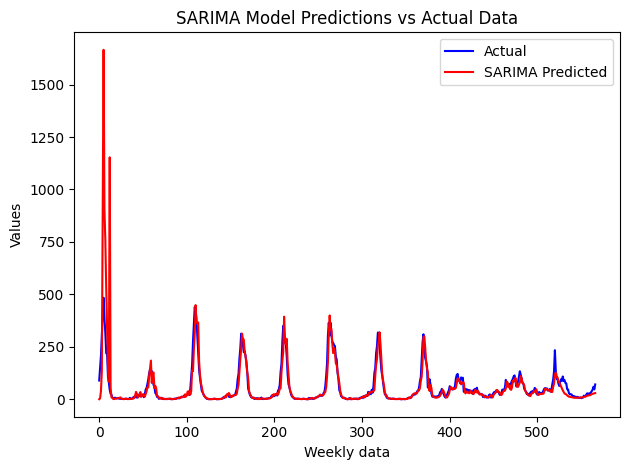

In [ ]:
model_sarima_opt = sm.tsa.statespace.SARIMAX(train["log"],
                                         order=(7,0,8),
                                         seasonal_order=(2,1,2,12),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
model_sarima_fit = model_sarima_opt.fit(disp=False)

pred_sarima = model_sarima_fit.predict(start=0, end=len(flu_clean_imputed) - 1)

pred_sarima = np.exp(pred_sarima) - 1
pred_data_sarima = pd.DataFrame({'pred': pred_sarima})
pred_data_sarima.index = flu_clean_imputed.index

# plt.figure(figsize=(12, 6))
plt.plot(flu_clean_imputed['value'], color="blue", label="Actual")
plt.plot(pred_data_sarima, color="red", label="SARIMA Predicted")
plt.title("SARIMA Model Predictions vs Actual Data")
plt.xlabel("Weekly data")
plt.ylabel("Values")
plt.tight_layout()
plt.legend()
plt.show()